In [7]:
# Load your data

import numpy as np
import pandas as pd
import shap
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, roc_curve, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns


expression_file = r'C:\Users\Neel Patel\Documents\Github Repositories\Machine-Learning-Biosciences-Final-Project\Project1\5_mr_50_cond\simulated_noNoise.txt'
ground_truth_file = r'C:\Users\Neel Patel\Documents\Github Repositories\Machine-Learning-Biosciences-Final-Project\Project1\5_mr_50_cond\bipartite_GRN.csv'

data = pd.read_csv(expression_file, sep="\t")
tg = data.iloc[:,0:100]

tg.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,3.520,7.5700,6.78,4.5300,6.94,3.36,9.300,4.9600,8.75,8.040,...,6.77,1.93,5.3900,4.85,4.380,8.24,11.000,5.810,5.030,8.420
1,4.770,2.5900,10.50,6.6900,5.19,4.64,10.200,3.8700,11.20,7.910,...,6.99,2.98,3.5000,8.36,7.880,3.30,12.100,8.180,4.600,7.920
2,2.020,2.5100,7.57,3.8600,4.30,1.80,9.510,2.7200,5.83,3.970,...,2.94,3.62,1.6100,4.85,3.910,6.50,7.860,2.950,0.961,2.630
3,5.690,7.7600,6.64,7.0300,6.07,4.47,11.700,5.2000,9.45,8.690,...,7.52,3.83,8.3200,7.26,7.960,5.67,12.700,9.250,5.180,8.350
4,0.351,0.0534,5.96,0.0143,4.18,6.19,0.225,0.0447,0.00,0.646,...,0.30,3.95,0.0547,5.20,0.136,3.08,0.113,0.117,0.103,0.239


## Regular Random Forest Regressor 

In [8]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score

def load_data(expression_file):
    data = pd.read_csv(expression_file, sep="\t")
    tf_expression = data.iloc[:, :100].values  
    tg_expression = data.iloc[:, 100:].values  
    return tf_expression, tg_expression

def train_models(tf_expression, tg_expression):
    models = []
    for i in range(tg_expression.shape[1]):
        model = RandomForestRegressor(n_estimators=100,max_features=None,random_state=6517)
        model.fit(tf_expression, tg_expression[:, i])
        models.append(model)
    return models

def infer_grn(models, threshold=0.03199140873560253):
    grn_edges = []
    for i, model in enumerate(models):
        importance = model.feature_importances_
        regulators = np.where(importance > threshold)[0]
        for reg in regulators:
            grn_edges.append((reg, i+100))  # TF ids are 0-99, TG ids are 100-199
      
    return grn_edges

def evaluate_grn(predicted_edges, ground_truth_file):
    ground_truth = pd.read_csv(ground_truth_file, header=None)
    ground_truth.head()
    ground_truth_set = set(tuple(x) for x in ground_truth.values)
    predicted_set = set(predicted_edges) #convert into a set to get the unique ordered pairs (also can't edit the sets themselves)
    
    tp = len(predicted_set & ground_truth_set)
    fp = len(predicted_set - ground_truth_set)
    fn = len(ground_truth_set - predicted_set)
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    print("HERE ARE TP,FP,FN")  
    print(tp,fp,fn)
    return precision, recall


# Load your data and adjust file path as necessary!
tf_expression, tg_expression = load_data(expression_file)

# Train a model for each target gene
models = train_models(tf_expression, tg_expression)

# Infer the gene regulatory network
predicted_grn_edges = infer_grn(models)


# Evaluate the GRN
precision, recall= evaluate_grn(predicted_grn_edges, ground_truth_file)

print(f"Precision: {precision}, Recall: {recall}")

HERE ARE TP,FP,FN
94 486 396
Precision: 0.16206896551724137, Recall: 0.19183673469387755


In [9]:
def infer_grn_scores(models):
    scores = []
    for model in models:
        # Using feature importances as the score
        scores.append(model.feature_importances_)
    return np.array(scores).T  # Transpose to align with the shape of tf_expression


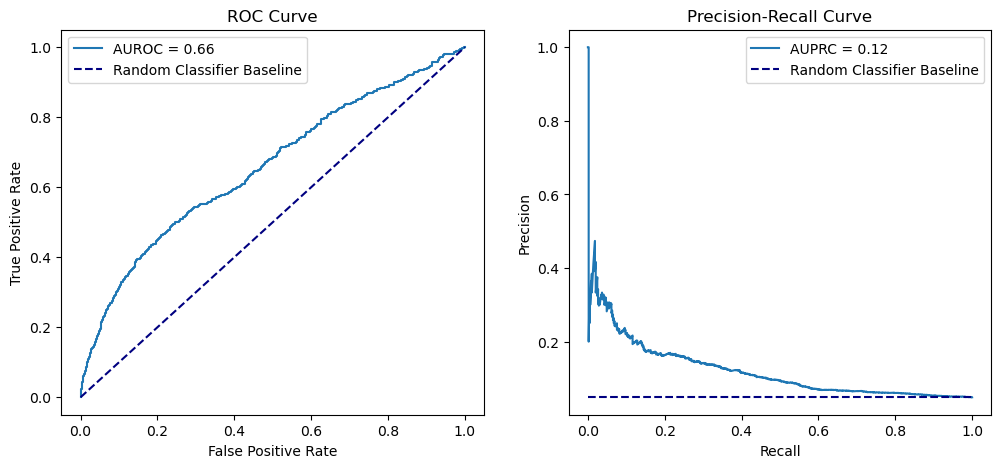

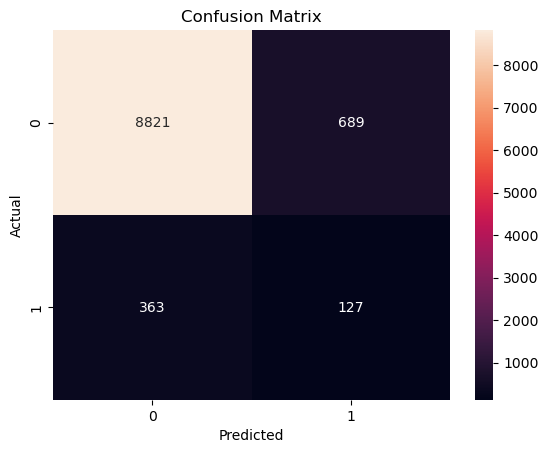

AUROC: 0.6567102298332582, AUPRC: 0.12144056034783374, Max F1 Score: 0.19586840091813315, Best Threshold: 0.02143187566460771


In [10]:
def evaluate_metrics(tf_expression, tg_expression, scores, ground_truth_file):
    # Prepare ground truth labels
    ground_truth = pd.read_csv(ground_truth_file, header=None)
    y_true = np.zeros_like(scores, dtype=int)
    for _, (tf, tg) in ground_truth.iterrows():
        y_true[tf, tg-100] = 1  # Adjust index for TGs

    # Flatten arrays for evaluations
    scores_flat = scores.flatten()
    y_true_flat = y_true.flatten()

    # Compute AUROC and AUPRC
    auroc = roc_auc_score(y_true_flat, scores_flat)
    auprc = average_precision_score(y_true_flat, scores_flat)

    # Compute precision-recall curve and F1 score
    precision, recall, thresholds = precision_recall_curve(y_true_flat, scores_flat)
    f1_scores = [2 * p * r / (p + r) for p, r in zip(precision, recall) if p + r > 0]
    max_f1_index = np.argmax(f1_scores)
    max_f1 = f1_scores[max_f1_index]
    best_threshold = thresholds[max_f1_index]

    # Plotting ROC Curve
    fpr, tpr, _ = roc_curve(y_true_flat, scores_flat)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f'AUROC = {auroc:.2f}')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Random Classifier Baseline')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()

    # Plotting Precision-Recall Curve
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label=f'AUPRC = {auprc:.2f}')
    no_skill = sum(y_true_flat) / len(y_true_flat)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', color='navy', label='Random Classifier Baseline')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

    # Displaying the confusion matrix for the best F1 score
    predictions = (scores_flat > best_threshold).astype(int)
    cm = confusion_matrix(y_true_flat, predictions)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    return auroc, auprc, max_f1, best_threshold

# Get scores from the GRN models
scores = infer_grn_scores(models)

# Evaluate and display metrics
auroc, auprc, max_f1, best_threshold = evaluate_metrics(tf_expression, tg_expression, scores, ground_truth_file)
print(f"AUROC: {auroc}, AUPRC: {auprc}, Max F1 Score: {max_f1}, Best Threshold: {best_threshold}")


# Random Forest Regressor with Friedman and Possion Criterion

## Friedman MSE

HERE ARE TP,FP,FN
95 477 395
Precision: 0.1660839160839161, Recall: 0.19387755102040816


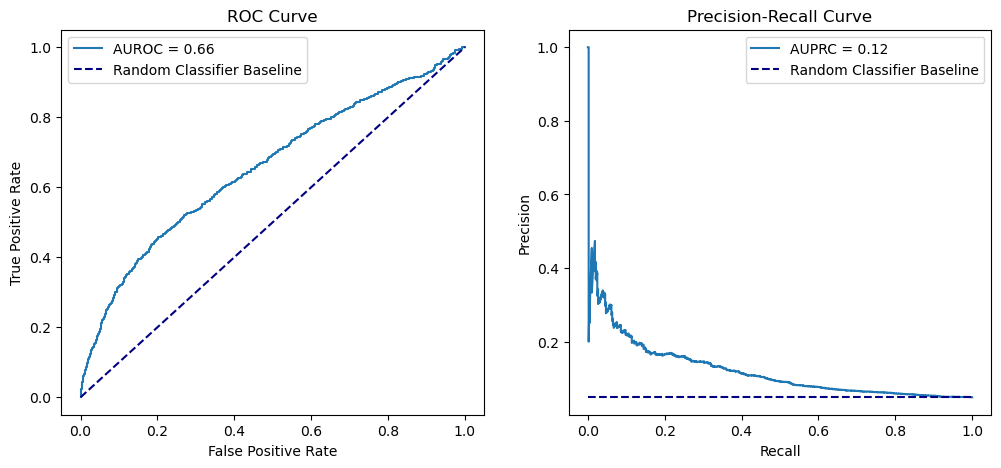

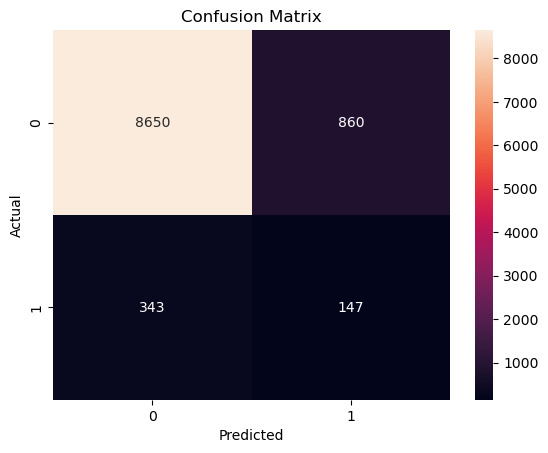

AUROC: 0.6559196549282174, AUPRC: 0.12176043074749571, Max F1 Score: 0.19759679572763686, Best Threshold: 0.0165631381922053


In [11]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score

def load_data(expression_file):
    data = pd.read_csv(expression_file, sep="\t")
    tf_expression = data.iloc[:, :100].values  
    tg_expression = data.iloc[:, 100:].values  
    return tf_expression, tg_expression

def train_models(tf_expression, tg_expression):
    models = []
    for i in range(tg_expression.shape[1]):
        model = RandomForestRegressor(n_estimators=100,max_features=None,random_state=6517,criterion='friedman_mse')
        model.fit(tf_expression, tg_expression[:, i])
        models.append(model)
    return models

def infer_grn(models, threshold=0.03199140873560253):
    grn_edges = []
    for i, model in enumerate(models):
        importance = model.feature_importances_
        regulators = np.where(importance > threshold)[0]
        for reg in regulators:
            grn_edges.append((reg, i+100))  # TF ids are 0-99, TG ids are 100-199
      
    return grn_edges

def evaluate_grn(predicted_edges, ground_truth_file):
    ground_truth = pd.read_csv(ground_truth_file, header=None)
    ground_truth.head()
    ground_truth_set = set(tuple(x) for x in ground_truth.values)
    predicted_set = set(predicted_edges) #convert into a set to get the unique ordered pairs (also can't edit the sets themselves)
    
    tp = len(predicted_set & ground_truth_set)
    fp = len(predicted_set - ground_truth_set)
    fn = len(ground_truth_set - predicted_set)
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    print("HERE ARE TP,FP,FN")  
    print(tp,fp,fn)
    return precision, recall

def infer_grn_scores(models):
    scores = []
    for model in models:
        # Using feature importances as the score
        scores.append(model.feature_importances_)
    return np.array(scores).T  # Transpose to align with the shape of tf_expression

def evaluate_metrics(tf_expression, tg_expression, scores, ground_truth_file):
    # Prepare ground truth labels
    ground_truth = pd.read_csv(ground_truth_file, header=None)
    y_true = np.zeros_like(scores, dtype=int)
    for _, (tf, tg) in ground_truth.iterrows():
        y_true[tf, tg-100] = 1  # Adjust index for TGs

    # Flatten arrays for evaluations
    scores_flat = scores.flatten()
    y_true_flat = y_true.flatten()

    # Compute AUROC and AUPRC
    auroc = roc_auc_score(y_true_flat, scores_flat)
    auprc = average_precision_score(y_true_flat, scores_flat)

    # Compute precision-recall curve and F1 score
    precision, recall, thresholds = precision_recall_curve(y_true_flat, scores_flat)
    f1_scores = [2 * p * r / (p + r) for p, r in zip(precision, recall) if p + r > 0]
    max_f1_index = np.argmax(f1_scores)
    max_f1 = f1_scores[max_f1_index]
    best_threshold = thresholds[max_f1_index]

    # Plotting ROC Curve
    fpr, tpr, _ = roc_curve(y_true_flat, scores_flat)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f'AUROC = {auroc:.2f}')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Random Classifier Baseline')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()

    # Plotting Precision-Recall Curve
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label=f'AUPRC = {auprc:.2f}')
    no_skill = sum(y_true_flat) / len(y_true_flat)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', color='navy', label='Random Classifier Baseline')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

    # Displaying the confusion matrix for the best F1 score
    predictions = (scores_flat > best_threshold).astype(int)
    cm = confusion_matrix(y_true_flat, predictions)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    return auroc, auprc, max_f1, best_threshold

# Load your data and adjust file path as necessary!
tf_expression, tg_expression = load_data(expression_file)

# Train a model for each target gene
models = train_models(tf_expression, tg_expression)

# Infer the gene regulatory network
predicted_grn_edges = infer_grn(models)


# Evaluate the GRN
precision, recall= evaluate_grn(predicted_grn_edges, ground_truth_file)

print(f"Precision: {precision}, Recall: {recall}")

# Get scores from the GRN models
scores = infer_grn_scores(models)

# Evaluate and display metrics
auroc, auprc, max_f1, best_threshold = evaluate_metrics(tf_expression, tg_expression, scores, ground_truth_file)
print(f"AUROC: {auroc}, AUPRC: {auprc}, Max F1 Score: {max_f1}, Best Threshold: {best_threshold}")



## Poisson 

HERE ARE TP,FP,FN
98 504 392
Precision: 0.16279069767441862, Recall: 0.2


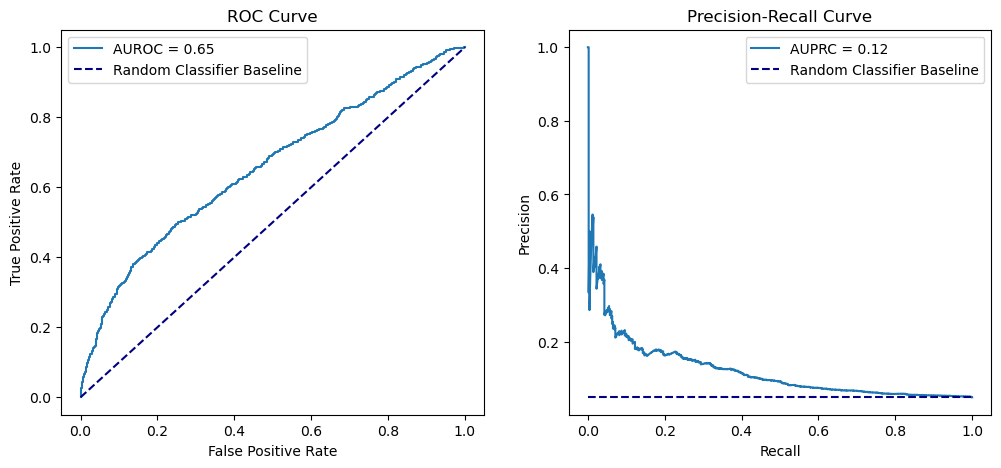

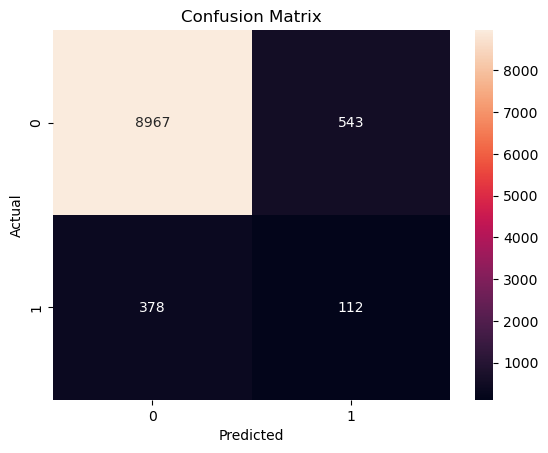

AUROC: 0.654811905834889, AUPRC: 0.12234837084089464, Max F1 Score: 0.19720767888307156, Best Threshold: 0.028981901029689318


In [12]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score

def load_data(expression_file):
    data = pd.read_csv(expression_file, sep="\t")
    tf_expression = data.iloc[:, :100].values  
    tg_expression = data.iloc[:, 100:].values  
    return tf_expression, tg_expression

def train_models(tf_expression, tg_expression):
    models = []
    for i in range(tg_expression.shape[1]):
        model = RandomForestRegressor(n_estimators=100,max_features=None,random_state=6517,criterion='poisson')
        model.fit(tf_expression, tg_expression[:, i])
        models.append(model)
    return models

def infer_grn(models, threshold=0.03199140873560253):
    grn_edges = []
    for i, model in enumerate(models):
        importance = model.feature_importances_
        regulators = np.where(importance > threshold)[0]
        for reg in regulators:
            grn_edges.append((reg, i+100))  # TF ids are 0-99, TG ids are 100-199
      
    return grn_edges

def evaluate_grn(predicted_edges, ground_truth_file):
    ground_truth = pd.read_csv(ground_truth_file, header=None)
    ground_truth.head()
    ground_truth_set = set(tuple(x) for x in ground_truth.values)
    predicted_set = set(predicted_edges) #convert into a set to get the unique ordered pairs (also can't edit the sets themselves)
    
    tp = len(predicted_set & ground_truth_set)
    fp = len(predicted_set - ground_truth_set)
    fn = len(ground_truth_set - predicted_set)
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    print("HERE ARE TP,FP,FN")  
    print(tp,fp,fn)
    return precision, recall

def infer_grn_scores(models):
    scores = []
    for model in models:
        # Using feature importances as the score
        scores.append(model.feature_importances_)
    return np.array(scores).T  # Transpose to align with the shape of tf_expression

def evaluate_metrics(tf_expression, tg_expression, scores, ground_truth_file):
    # Prepare ground truth labels
    ground_truth = pd.read_csv(ground_truth_file, header=None)
    y_true = np.zeros_like(scores, dtype=int)
    for _, (tf, tg) in ground_truth.iterrows():
        y_true[tf, tg-100] = 1  # Adjust index for TGs

    # Flatten arrays for evaluations
    scores_flat = scores.flatten()
    y_true_flat = y_true.flatten()

    # Compute AUROC and AUPRC
    auroc = roc_auc_score(y_true_flat, scores_flat)
    auprc = average_precision_score(y_true_flat, scores_flat)

    # Compute precision-recall curve and F1 score
    precision, recall, thresholds = precision_recall_curve(y_true_flat, scores_flat)
    f1_scores = [2 * p * r / (p + r) for p, r in zip(precision, recall) if p + r > 0]
    max_f1_index = np.argmax(f1_scores)
    max_f1 = f1_scores[max_f1_index]
    best_threshold = thresholds[max_f1_index]

    # Plotting ROC Curve
    fpr, tpr, _ = roc_curve(y_true_flat, scores_flat)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f'AUROC = {auroc:.2f}')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Random Classifier Baseline')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()

    # Plotting Precision-Recall Curve
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label=f'AUPRC = {auprc:.2f}')
    no_skill = sum(y_true_flat) / len(y_true_flat)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', color='navy', label='Random Classifier Baseline')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

    # Displaying the confusion matrix for the best F1 score
    predictions = (scores_flat > best_threshold).astype(int)
    cm = confusion_matrix(y_true_flat, predictions)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    return auroc, auprc, max_f1, best_threshold

# Load your data and adjust file path as necessary!
tf_expression, tg_expression = load_data(expression_file)

# Train a model for each target gene
models = train_models(tf_expression, tg_expression)

# Infer the gene regulatory network
predicted_grn_edges = infer_grn(models)


# Evaluate the GRN
precision, recall= evaluate_grn(predicted_grn_edges, ground_truth_file)

print(f"Precision: {precision}, Recall: {recall}")

# Get scores from the GRN models
scores = infer_grn_scores(models)

# Evaluate and display metrics
auroc, auprc, max_f1, best_threshold = evaluate_metrics(tf_expression, tg_expression, scores, ground_truth_file)
print(f"AUROC: {auroc}, AUPRC: {auprc}, Max F1 Score: {max_f1}, Best Threshold: {best_threshold}")



# SHAP ANALYSIS

In [19]:
import numpy as np
import pandas as pd
import shap
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, roc_curve, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Function to load data
def load_data(expression_file):
    data = pd.read_csv(expression_file, sep="\t")
    tf_expression = data.iloc[:, :100].values  # Assuming TFs are the first 100 columns
    tg_expression = data.iloc[:, 100:].values  # Assuming TGs are the next 100 columns
    return tf_expression, tg_expression

# Function to train models and calculate SHAP values
def train_models_with_shap(tf_expression, tg_expression):
    models = []
    shap_values_list = []
    for i in range(tg_expression.shape[1]):
        model = RandomForestRegressor(n_estimators=100,max_features=None,random_state=6517)
        model.fit(tf_expression, tg_expression[:, i])

        # Calculate SHAP values
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(tf_expression)
        shap_values_list.append(shap_values)

        models.append(model)
    return models, shap_values_list

# Function to infer GRN with SHAP scores
def infer_grn_with_shap_scores(models, shap_values_list):
    scores = np.zeros((100, 100))  # Assuming 100 TFs and 100 TGs
    for i, shap_values in enumerate(shap_values_list):
        importance = np.abs(shap_values).mean(axis=0)
        scores[:, i] = importance
    return scores

# Evaluation function
def evaluate_metrics(tf_expression, tg_expression, scores, ground_truth_file):
    ground_truth = pd.read_csv(ground_truth_file, header=None)
    y_true = np.zeros_like(scores, dtype=int)
    for _, (tf, tg) in ground_truth.iterrows():
        y_true[tf, tg-100] = 1

    scores_flat = scores.flatten()
    y_true_flat = y_true.flatten()

    auroc = roc_auc_score(y_true_flat, scores_flat)
    auprc = average_precision_score(y_true_flat, scores_flat)

    precision, recall, thresholds = precision_recall_curve(y_true_flat, scores_flat)
    f1_scores = [2 * p * r / (p + r) for p, r in zip(precision, recall) if p + r > 0]
    max_f1_index = np.argmax(f1_scores)
    max_f1 = f1_scores[max_f1_index]
    best_threshold = thresholds[max_f1_index]

    fpr, tpr, _ = roc_curve(y_true_flat, scores_flat)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f'AUROC = {auroc:.2f}')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Random Classifier Baseline')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label=f'AUPRC = {auprc:.2f}')
    no_skill = sum(y_true_flat) / len(y_true_flat)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', color='navy', label='Random Classifier Baseline')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

    predictions = (scores_flat > best_threshold).astype(int)
    cm = confusion_matrix(y_true_flat, predictions)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    return auroc, auprc, max_f1, best_threshold

# Load your data

expression_file = r'C:\Users\Neel Patel\Documents\Github Repositories\Machine-Learning-Biosciences-Final-Project\Project1\5_mr_50_cond\simulated_noNoise.txt'
ground_truth_file = r'C:\Users\Neel Patel\Documents\Github Repositories\Machine-Learning-Biosciences-Final-Project\Project1\5_mr_50_cond\bipartite_GRN.csv'

tf_expression, tg_expression = load_data(expression_file)

# Train models and calculate SHAP values
models, shap_values_list = train_models_with_shap(tf_expression, tg_expression)

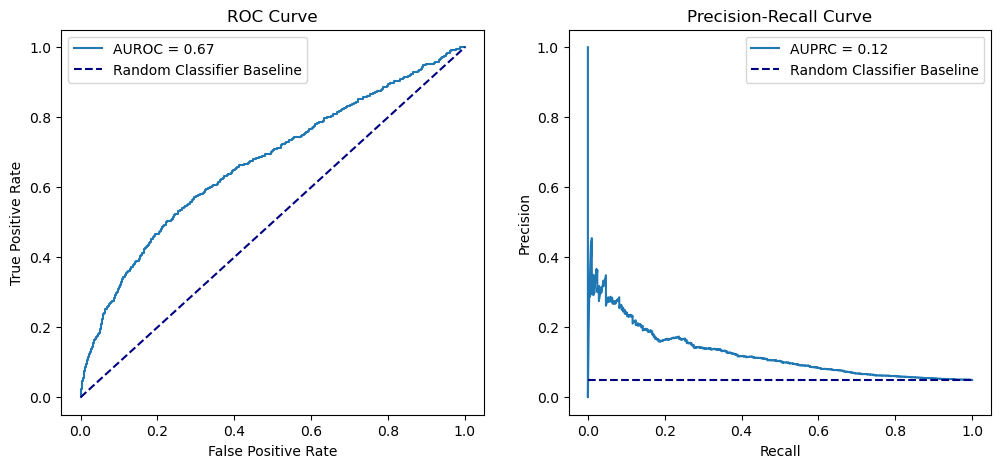

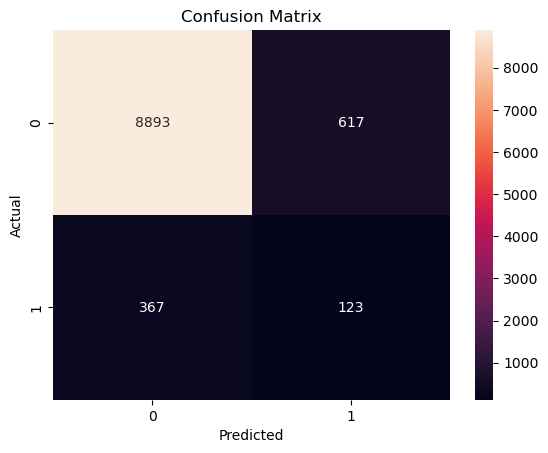

AUROC: 0.6690982639112427, AUPRC: 0.12393626308705427, Max F1 Score: 0.20146222583265638, Best Threshold: 0.06632011261803467


In [20]:
shap_scores = infer_grn_with_shap_scores(models,shap_values_list)
auroc, auprc, max_f1, best_threshold = evaluate_metrics(tf_expression,tg_expression, shap_scores,ground_truth_file )
print(f"AUROC: {auroc}, AUPRC: {auprc}, Max F1 Score: {max_f1}, Best Threshold: {best_threshold}")



# Shap with correlation pruning!


In [23]:
def correlation_pruning_with_shap(shap_scores, expression_data, threshold):
    pruned_scores = np.zeros_like(shap_scores)
    for tf in range(shap_scores.shape[0]):  # Iterate over all TFs
        for tg in range(shap_scores.shape[1]):  # Iterate over all TGs
            correlation, _ = pearsonr(expression_data[:, tf], expression_data[:, tg + 100])  # Adjust index for TGs
            if abs(correlation) > threshold:
                pruned_scores[tf, tg] = shap_scores[tf, tg]
    return pruned_scores


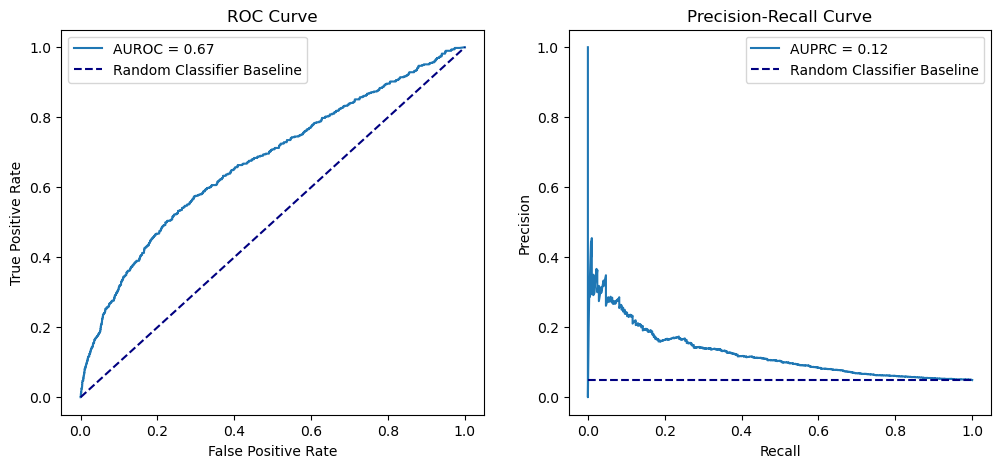

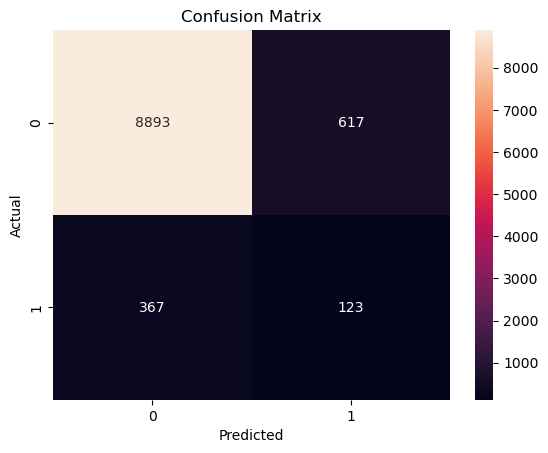

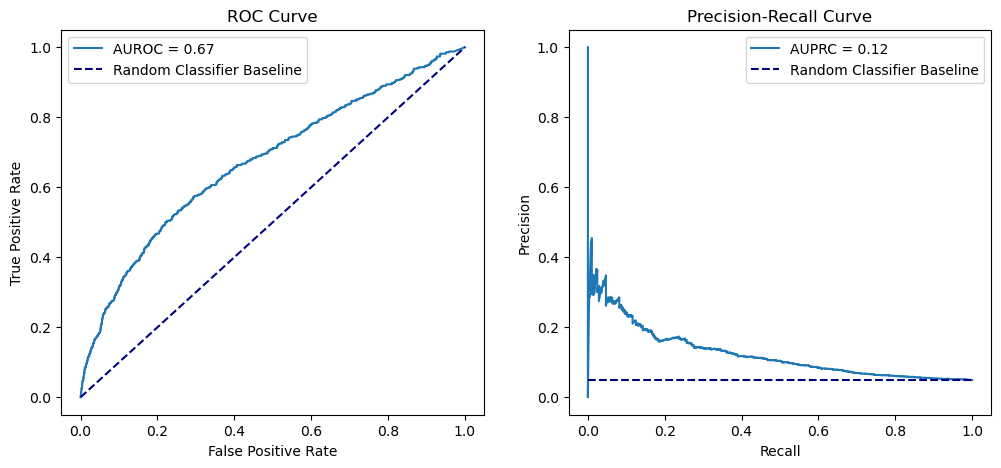

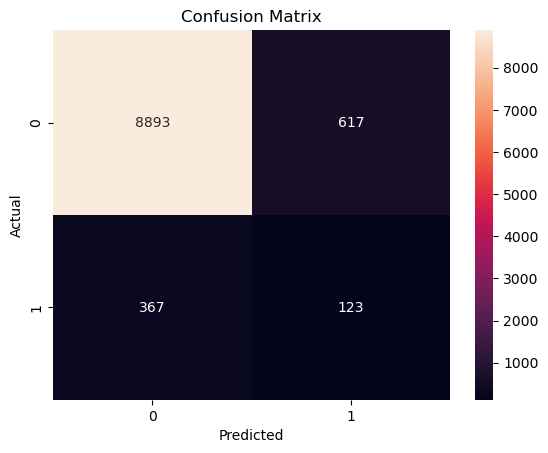

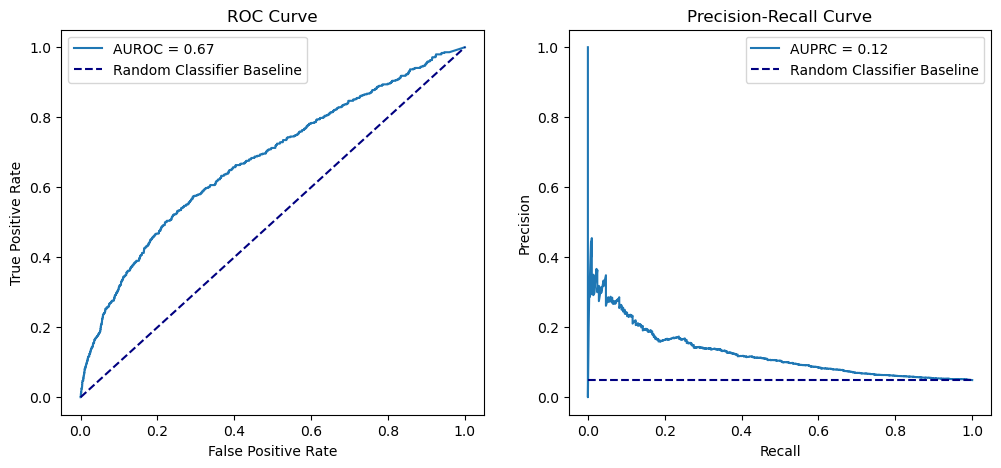

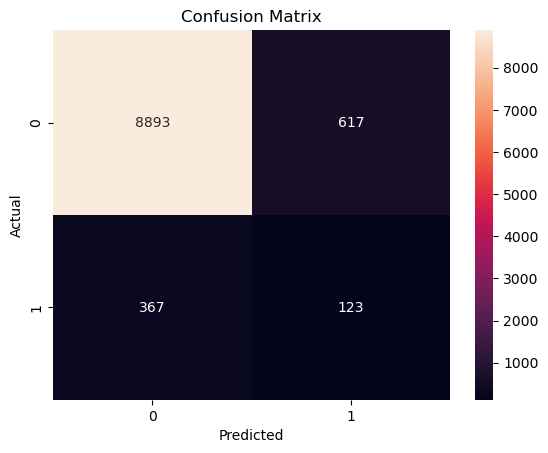

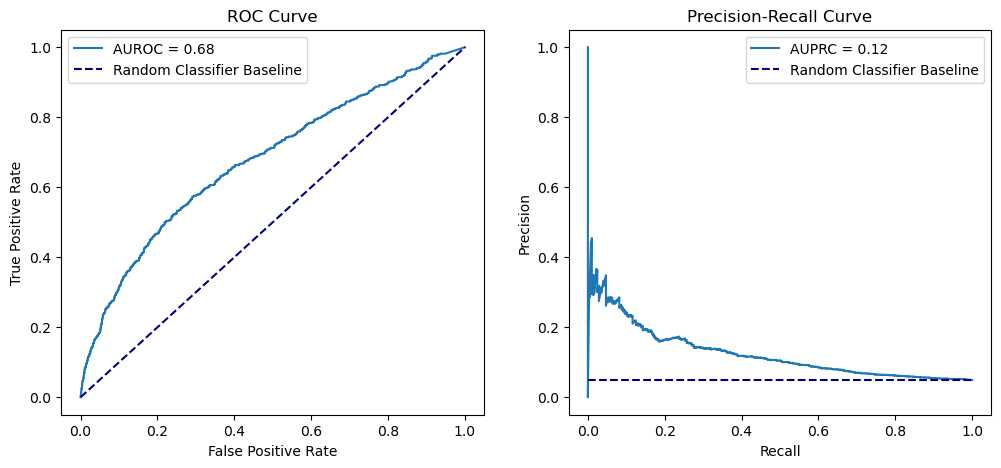

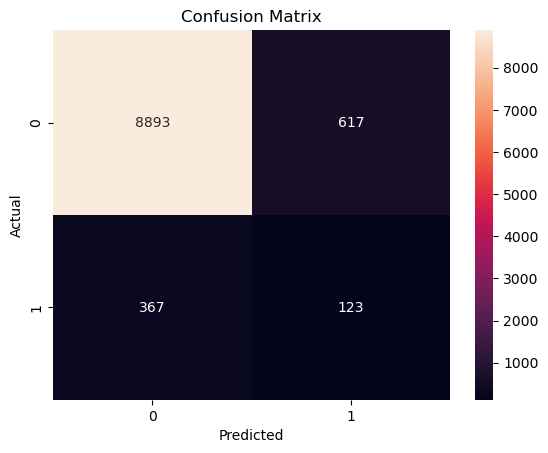

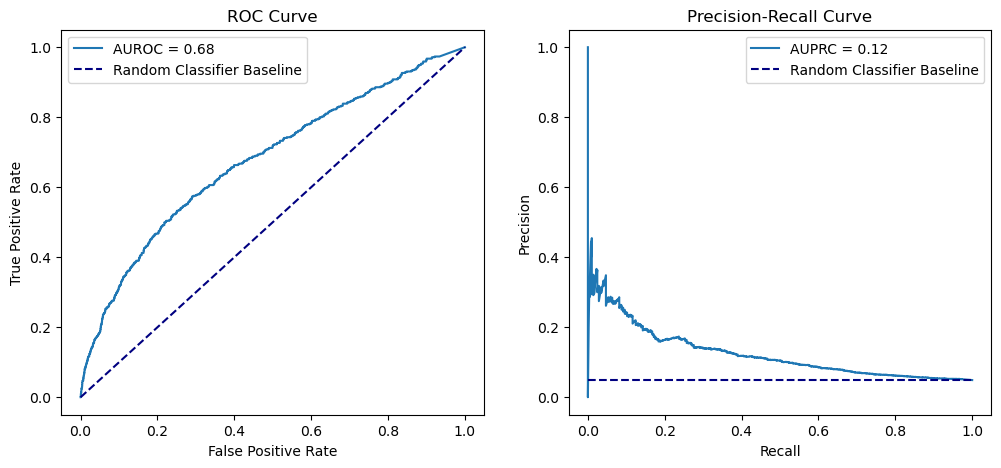

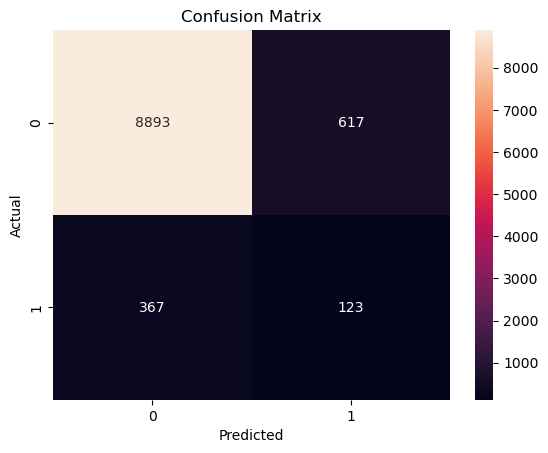

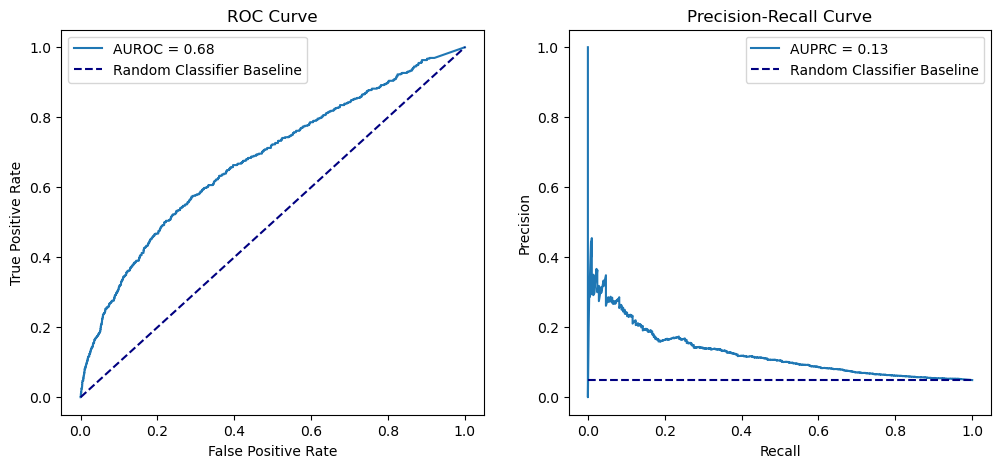

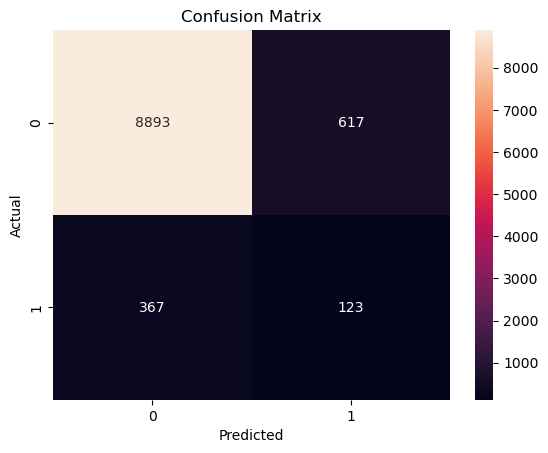

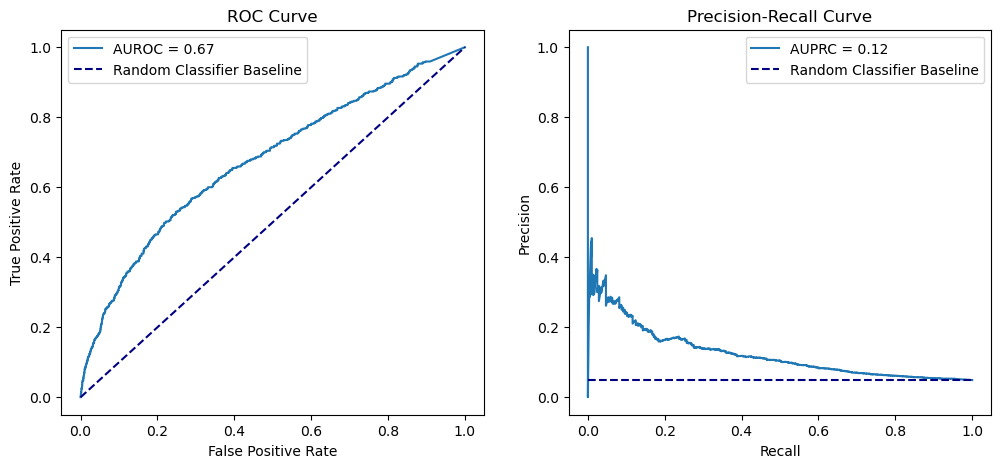

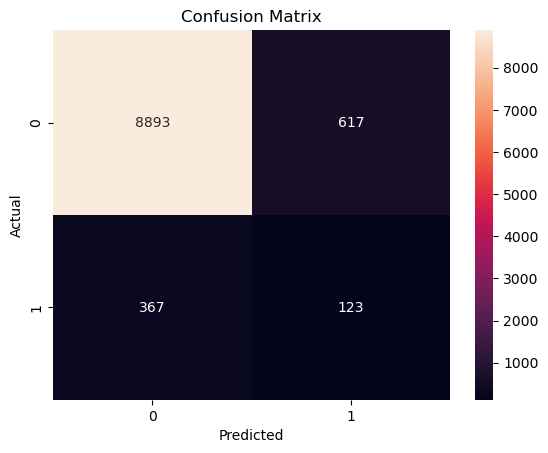

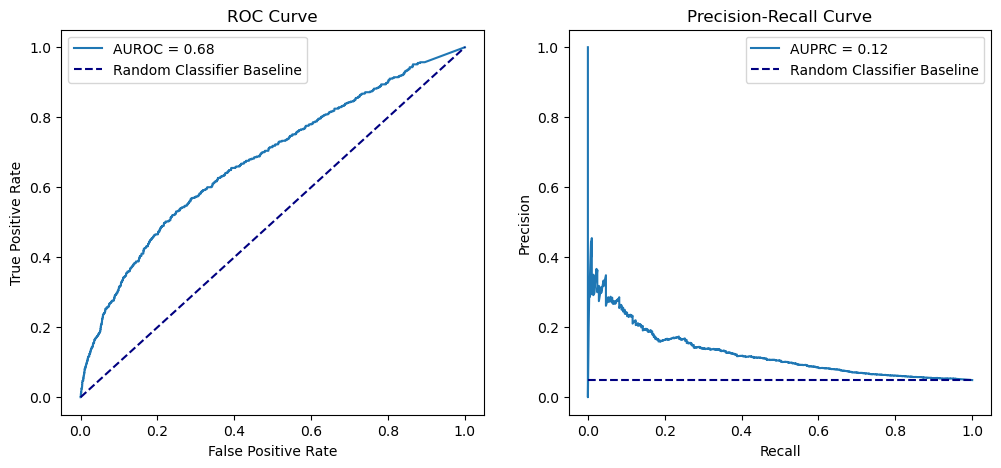

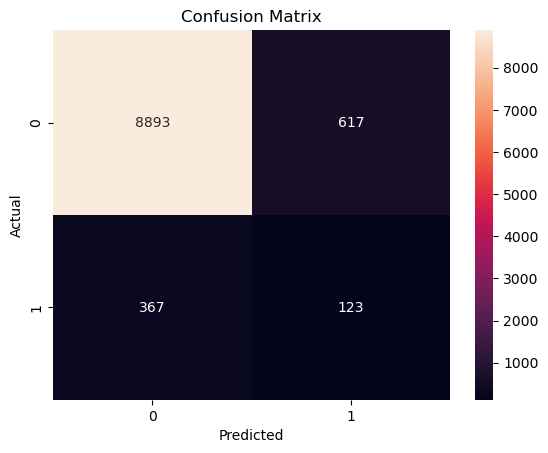

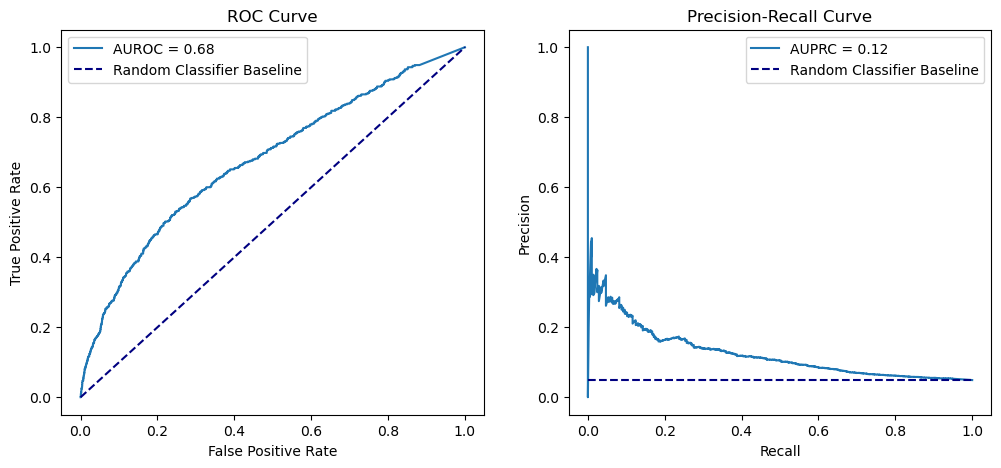

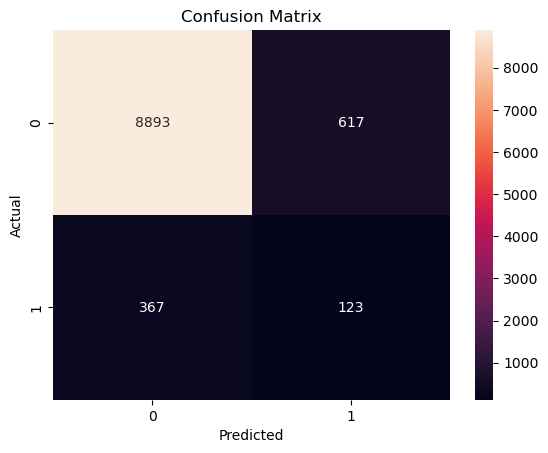

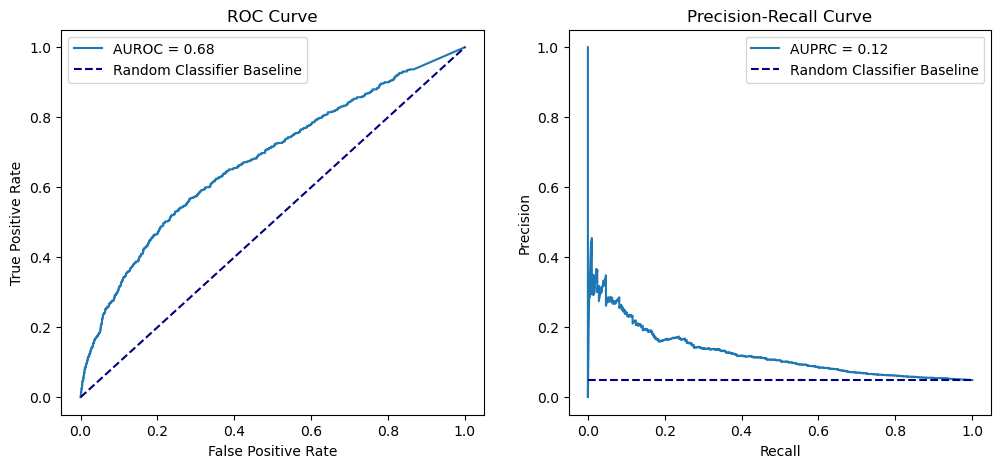

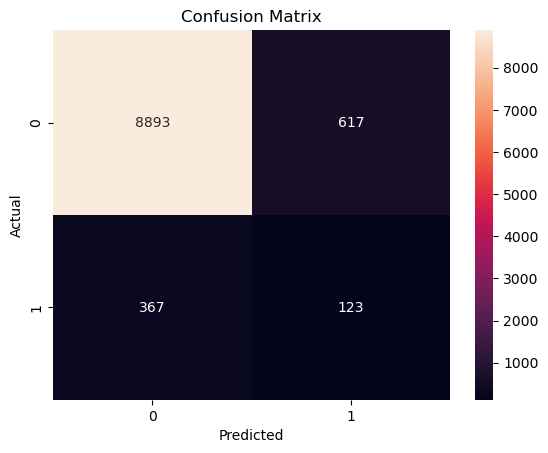

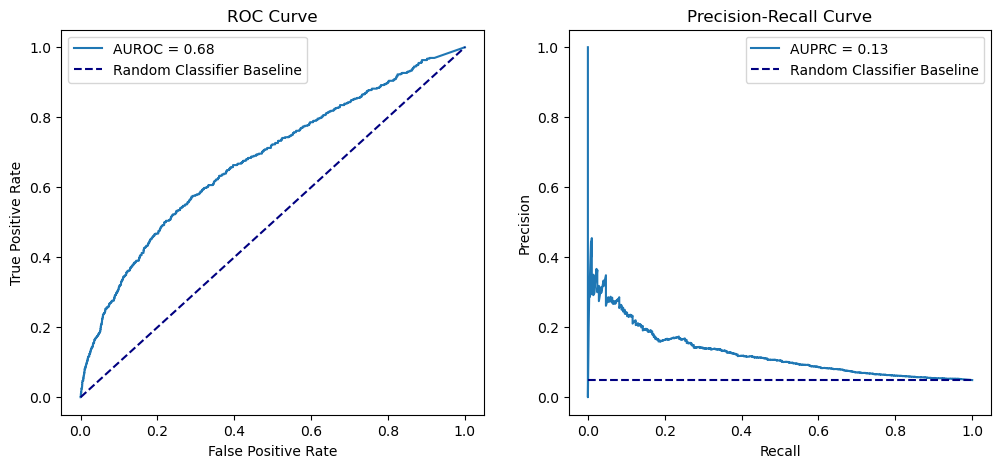

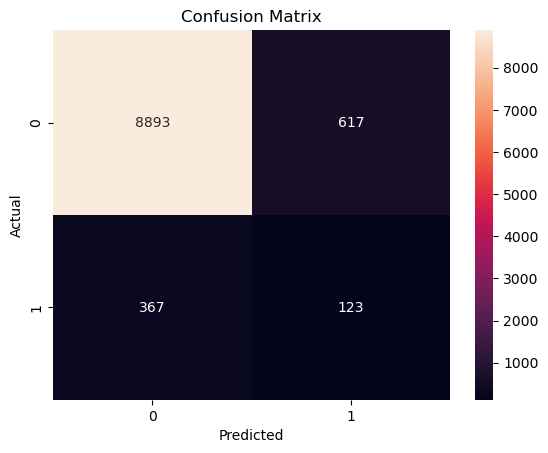

Best Threshold: 0.06000000000000001, Best AUROC: 0.677712182664864
AUROC: 0.677712182664864, AUPRC: 0.1250484379667509, Max F1 Score: 0.20146222583265638


In [24]:
def find_best_threshold_with_pruning(tf_expression, tg_expression, shap_scores, ground_truth_file, correlation_thresholds):
    best_auc = 0
    best_threshold = 0
    best_pruned_scores = None

    for threshold in correlation_thresholds:
        pruned_scores = correlation_pruning_with_shap(shap_scores, expression_data, threshold)
        auroc, auprc, max_f1, _ = evaluate_metrics(tf_expression, tg_expression, pruned_scores, ground_truth_file)
        
        if auroc > best_auc:  # Update the best threshold based on AUROC or other criteria
            best_auc = auroc
            best_threshold = threshold
            best_pruned_scores = pruned_scores

    return best_threshold, best_pruned_scores, best_auc

# Get SHAP scores from the GRN models
shap_scores = infer_grn_with_shap_scores(models, shap_values_list)

# Find the best threshold with pruning
correlation_thresholds = np.linspace(0.01, 0.1, 10)  # Example range of thresholds
best_threshold, best_pruned_scores, best_auc = find_best_threshold_with_pruning(tf_expression, tg_expression, shap_scores, ground_truth_file, correlation_thresholds)


# Evaluate and display metrics for the best threshold
auroc, auprc, max_f1, _ = evaluate_metrics(tf_expression, tg_expression, best_pruned_scores, ground_truth_file)
print(f"Best Threshold: {best_threshold}, Best AUROC: {best_auc}")
print(f"AUROC: {auroc}, AUPRC: {auprc}, Max F1 Score: {max_f1}")


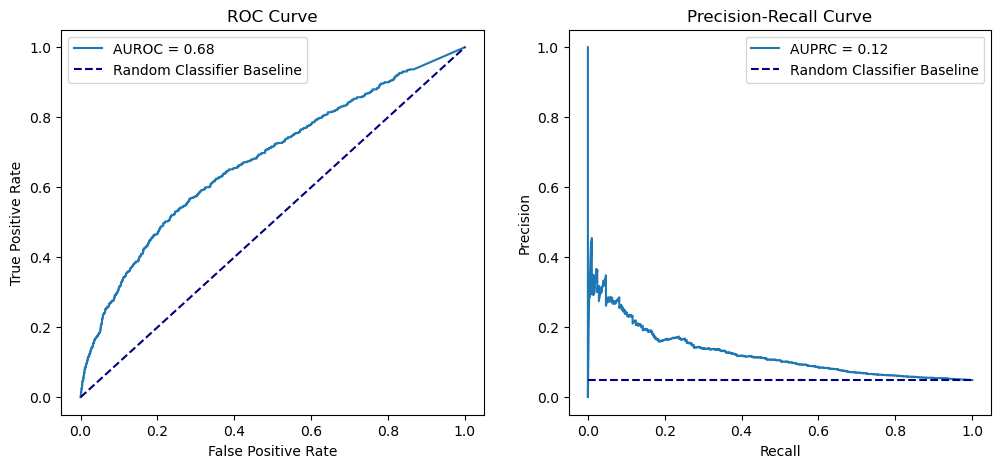

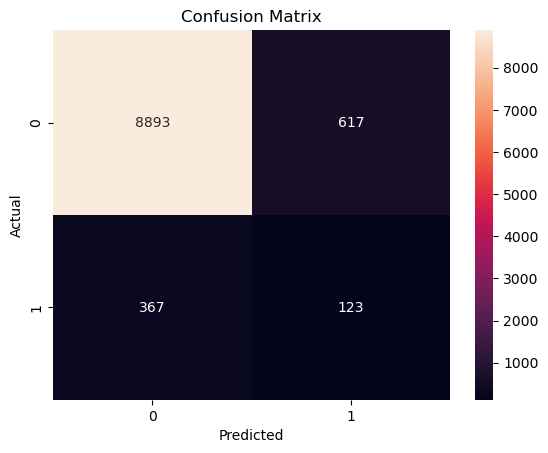

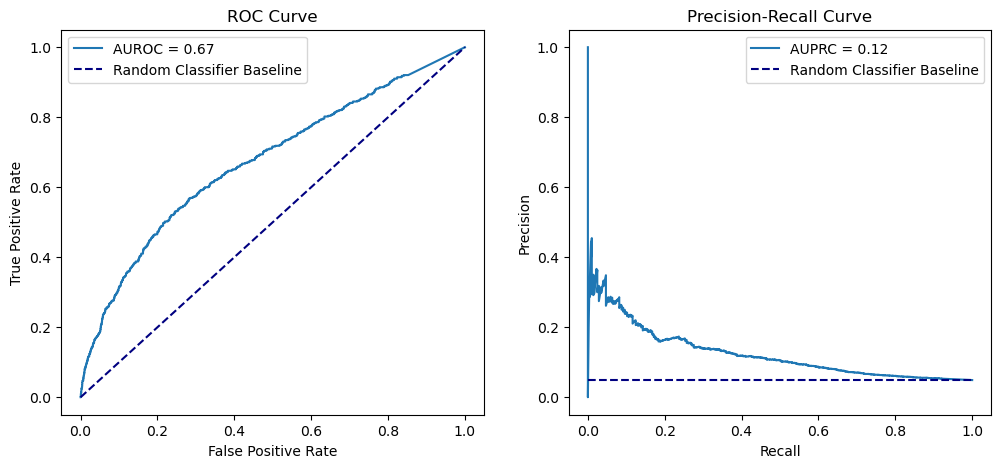

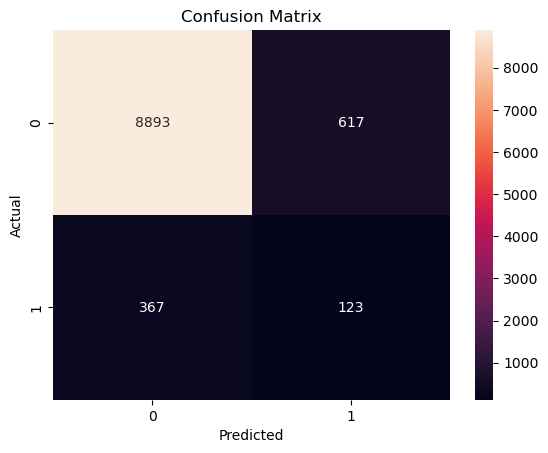

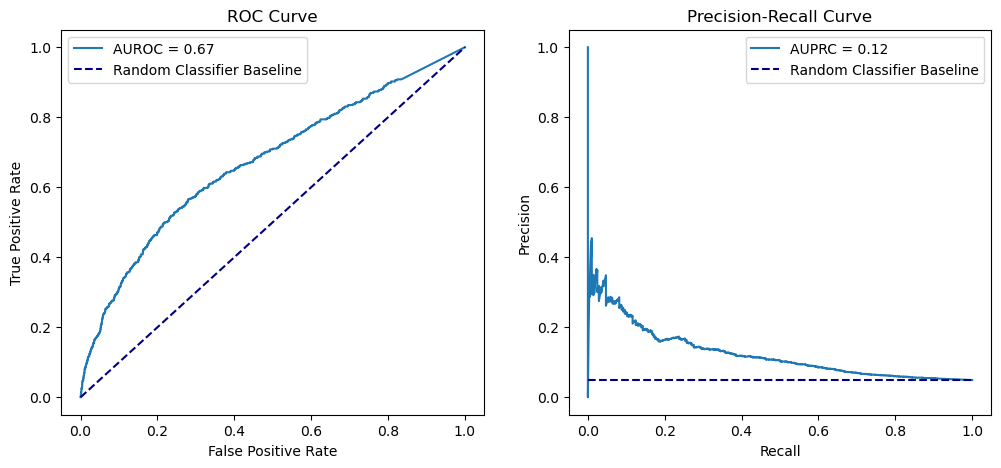

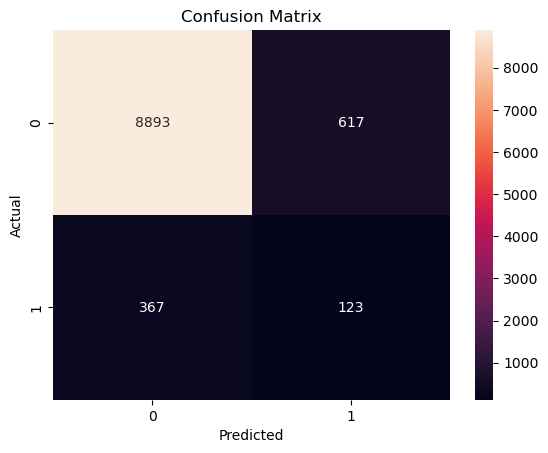

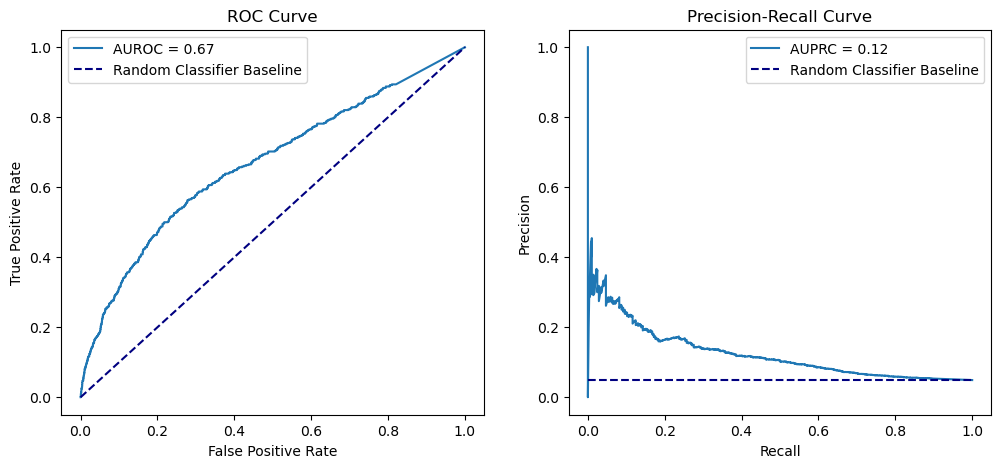

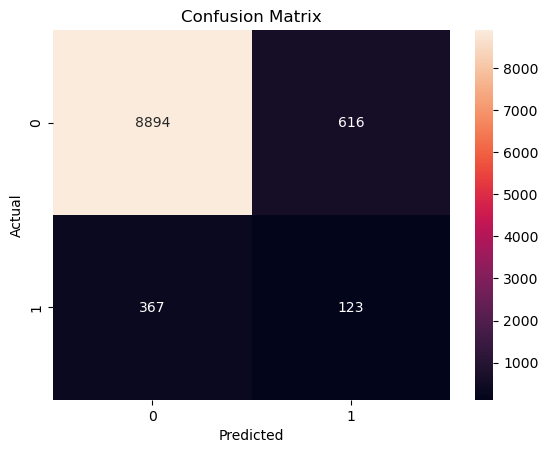

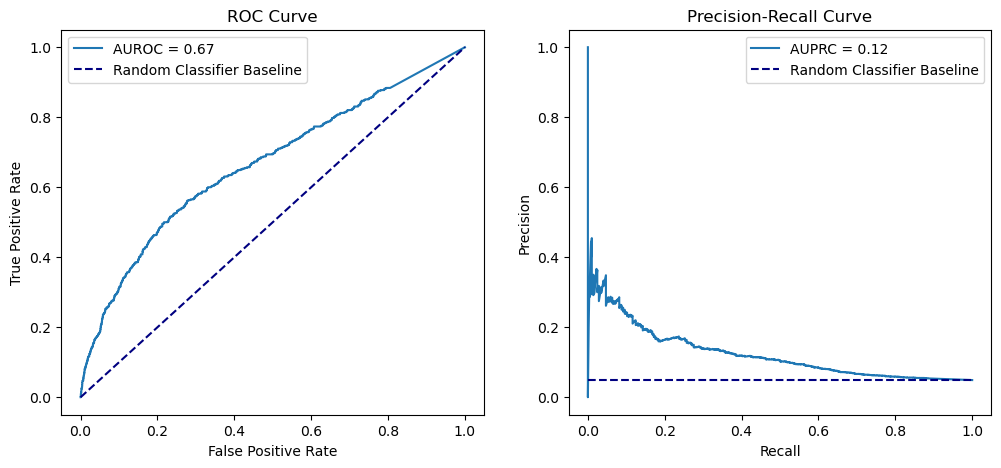

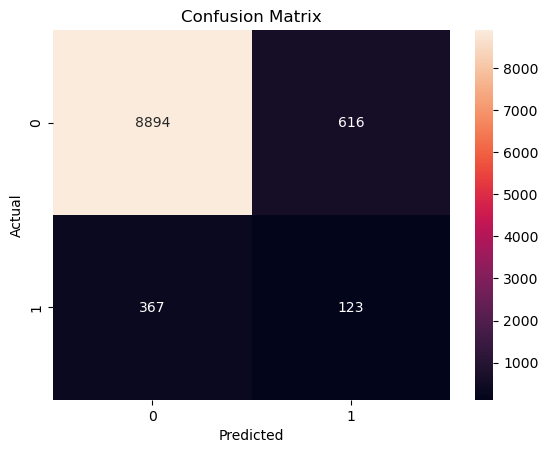

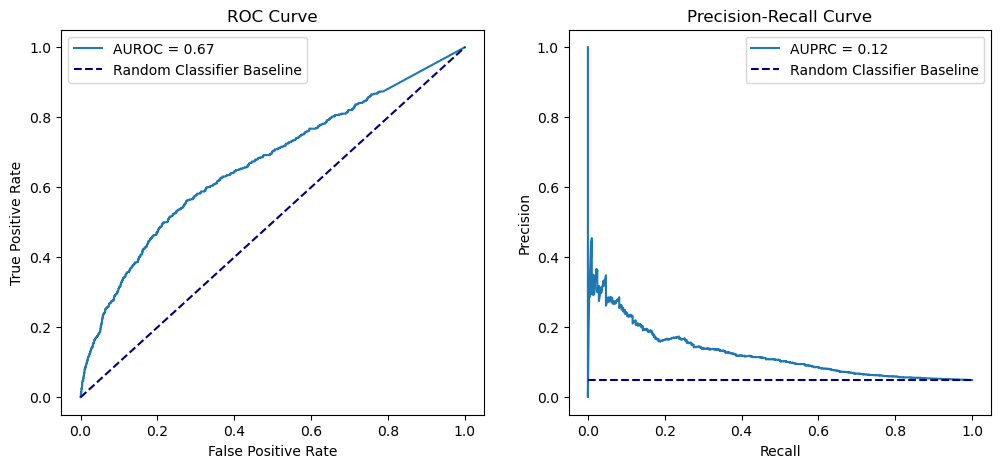

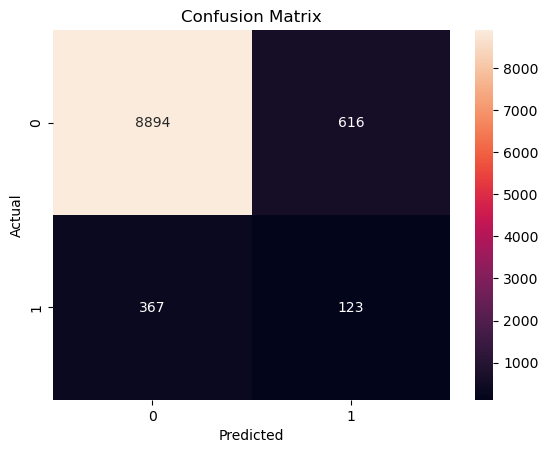

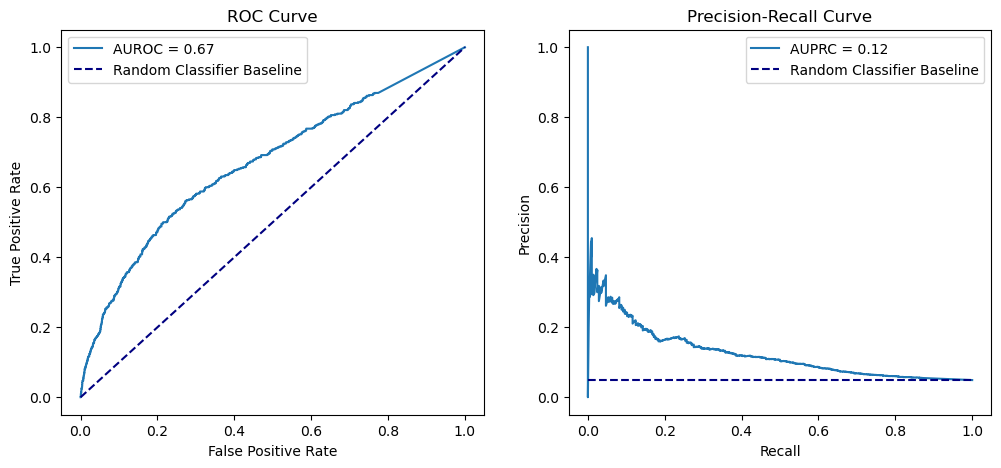

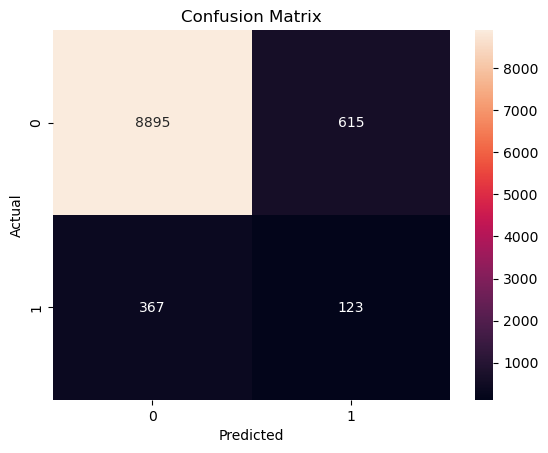

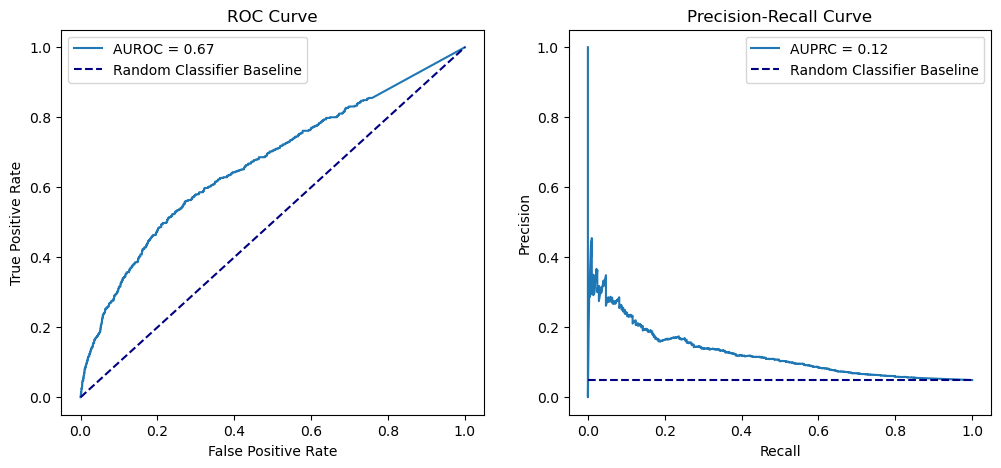

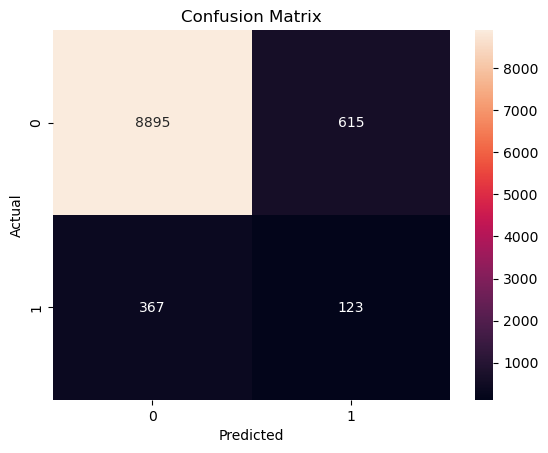

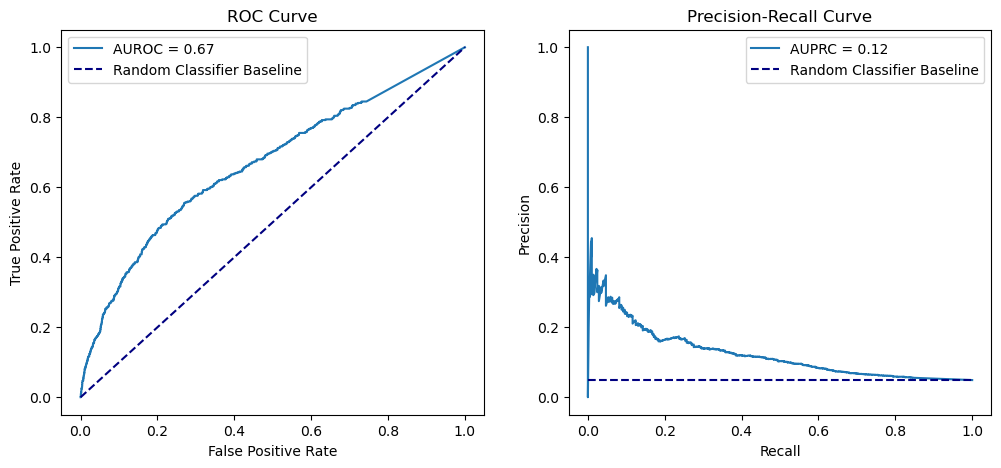

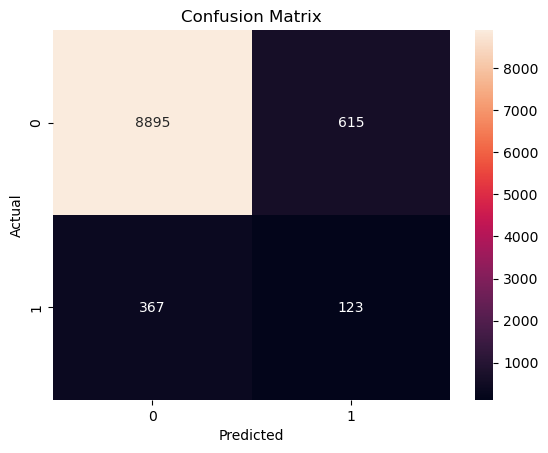

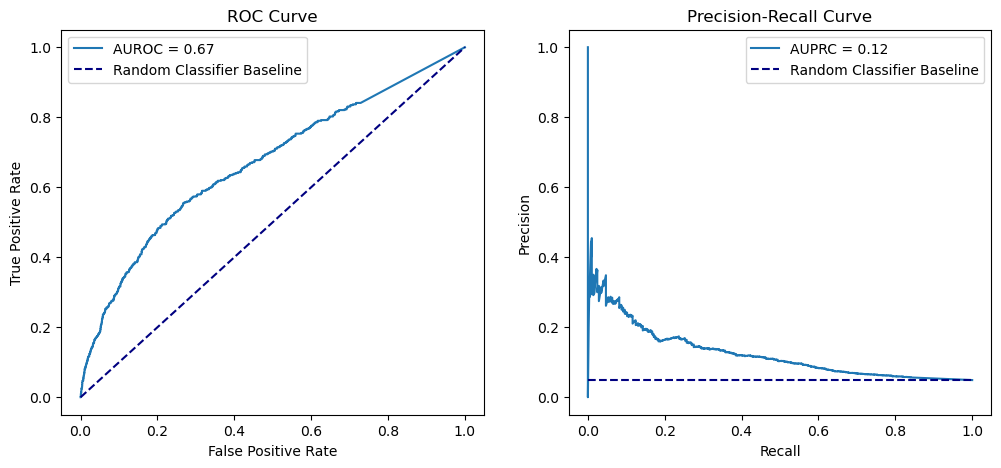

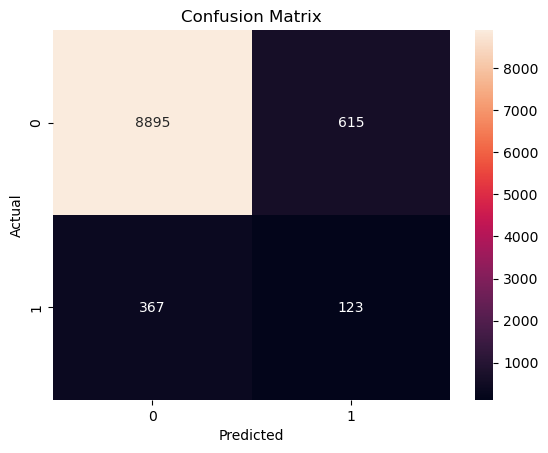

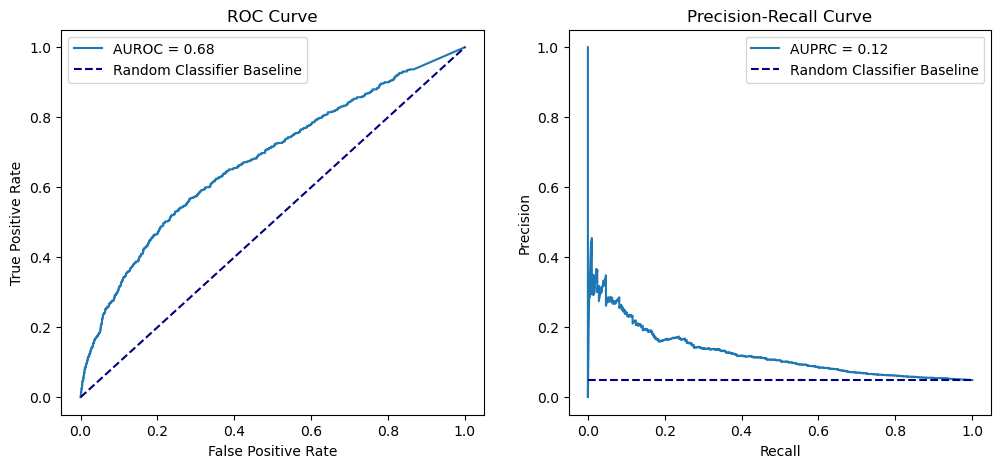

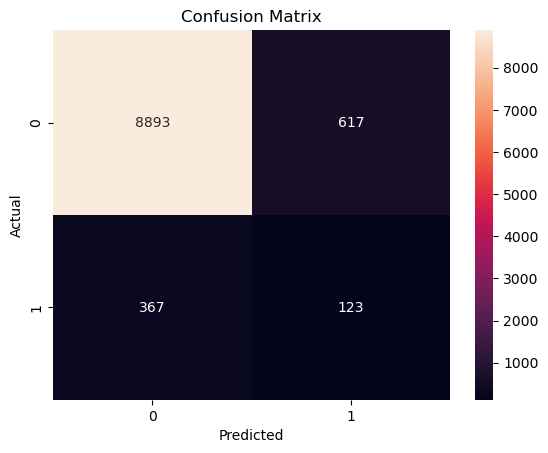

Best Threshold: 0.1, Best AUROC: 0.6756128886885985
AUROC: 0.6756128886885985, AUPRC: 0.12470840713948905, Max F1 Score: 0.20146222583265638


In [26]:
# Find the best threshold with pruning
correlation_thresholds = np.linspace(0.1, 0.2, 10)  # Example range of thresholds
best_threshold, best_pruned_scores, best_auc = find_best_threshold_with_pruning(tf_expression, tg_expression, shap_scores, ground_truth_file, correlation_thresholds)


# Evaluate and display metrics for the best threshold
auroc, auprc, max_f1, _ = evaluate_metrics(tf_expression, tg_expression, best_pruned_scores, ground_truth_file)
print(f"Best Threshold: {best_threshold}, Best AUROC: {best_auc}")
print(f"AUROC: {auroc}, AUPRC: {auprc}, Max F1 Score: {max_f1}")

## SHAP with weighted correlation

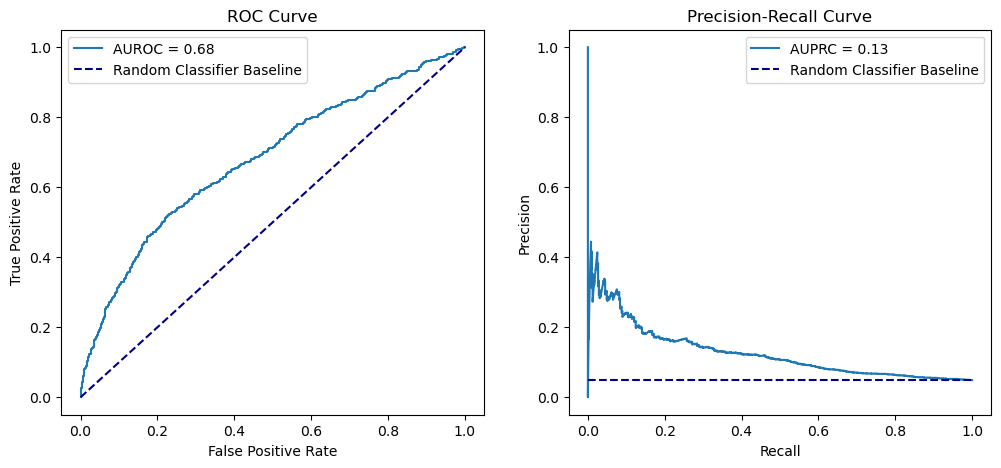

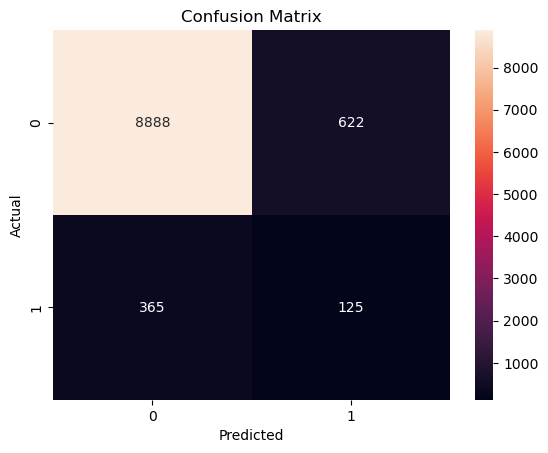

AUROC: 0.6792079229168009, AUPRC: 0.12631514426760304, Max F1 Score: 0.2035541195476575


In [27]:

import numpy as np
import pandas as pd
import shap
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, roc_curve, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Function to load data
def load_data(expression_file):
    data = pd.read_csv(expression_file, sep="\t")
    tf_expression = data.iloc[:, :100].values  # Assuming TFs are the first 100 columns
    tg_expression = data.iloc[:, 100:].values  # Assuming TGs are the next 100 columns
    return tf_expression, tg_expression

# Function to train models and calculate SHAP values
def train_models_with_shap(tf_expression, tg_expression):
    models = []
    shap_values_list = []
    for i in range(tg_expression.shape[1]):
        model = RandomForestRegressor(n_estimators=100,max_features=None,random_state=6517)
        model.fit(tf_expression, tg_expression[:, i])

        # Calculate SHAP values
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(tf_expression)
        shap_values_list.append(shap_values)

        models.append(model)
    return models, shap_values_list

# Function to infer GRN with SHAP scores
def infer_grn_with_shap_scores(models, shap_values_list):
    scores = np.zeros((100, 100))  # Assuming 100 TFs and 100 TGs
    for i, shap_values in enumerate(shap_values_list):
        importance = np.abs(shap_values).mean(axis=0)
        scores[:, i] = importance
    return scores

# Weighted Correlation Pruning Function
def weighted_correlation_pruning(shap_scores, expression_data, weight_factor):
    weighted_scores = np.zeros_like(shap_scores)
    num_tfs = shap_scores.shape[0]  # Assuming the number of TFs
    num_tgs = shap_scores.shape[1]  # Assuming the number of TGs

    for tf in range(num_tfs):
        for tg in range(num_tgs):
            tg_index = num_tfs + tg  # Adjust index for TGs
            correlation, _ = pearsonr(expression_data[:, tf], expression_data[:, tg_index])
            weighted_scores[tf, tg] = shap_scores[tf, tg] * (1 + abs(correlation) * weight_factor)

    return weighted_scores

# Evaluation function
def evaluate_metrics(tf_expression, tg_expression, scores, ground_truth_file):
    ground_truth = pd.read_csv(ground_truth_file, header=None)
    y_true = np.zeros_like(scores, dtype=int)
    for _, (tf, tg) in ground_truth.iterrows():
        y_true[tf, tg-100] = 1

    scores_flat = scores.flatten()
    y_true_flat = y_true.flatten()

    auroc = roc_auc_score(y_true_flat, scores_flat)
    auprc = average_precision_score(y_true_flat, scores_flat)

    precision, recall, thresholds = precision_recall_curve(y_true_flat, scores_flat)
    f1_scores = [2 * p * r / (p + r) for p, r in zip(precision, recall) if p + r > 0]
    max_f1_index = np.argmax(f1_scores)
    max_f1 = f1_scores[max_f1_index]
    best_threshold = thresholds[max_f1_index]

    fpr, tpr, _ = roc_curve(y_true_flat, scores_flat)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f'AUROC = {auroc:.2f}')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Random Classifier Baseline')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label=f'AUPRC = {auprc:.2f}')
    no_skill = sum(y_true_flat) / len(y_true_flat)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', color='navy', label='Random Classifier Baseline')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

    predictions = (scores_flat > best_threshold).astype(int)
    cm = confusion_matrix(y_true_flat, predictions)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    return auroc, auprc, max_f1, best_threshold

# Load your data
expression_file = r'C:\Users\Neel Patel\Documents\Github Repositories\Machine-Learning-Biosciences-Final-Project\Project1\5_mr_50_cond\simulated_noNoise.txt'
ground_truth_file = r'C:\Users\Neel Patel\Documents\Github Repositories\Machine-Learning-Biosciences-Final-Project\Project1\5_mr_50_cond\bipartite_GRN.csv'

tf_expression, tg_expression = load_data(expression_file)

# Concatenate TF and TG expression data for correlation analysis
expression_data = np.concatenate([tf_expression, tg_expression], axis=1)

# Train models and calculate SHAP values
models, shap_values_list = train_models_with_shap(tf_expression, tg_expression)

# Get SHAP scores from the GRN models
shap_scores = infer_grn_with_shap_scores(models, shap_values_list)

# Apply weighted correlation pruning
pruned_scores = weighted_correlation_pruning(shap_scores, expression_data, weight_factor=100)

# Evaluate and display metrics for the pruned GRN
auroc, auprc, max_f1, _ = evaluate_metrics(tf_expression, tg_expression, pruned_scores, ground_truth_file)
print(f"AUROC: {auroc}, AUPRC: {auprc}, Max F1 Score: {max_f1}")


## SHAP weighted correlation with poisson criterion

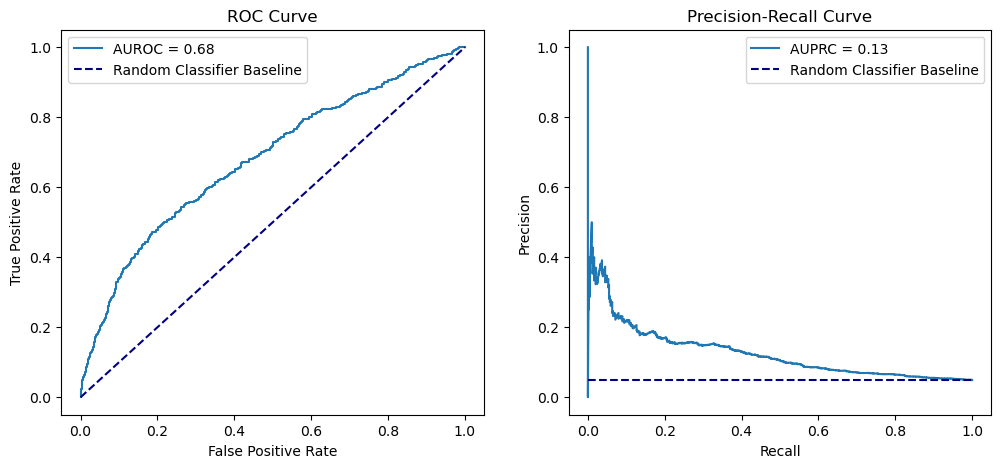

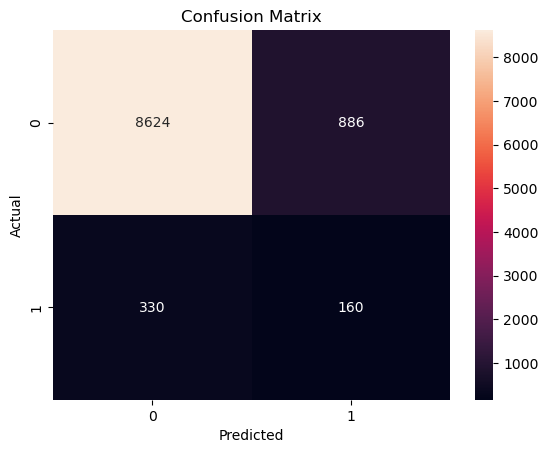

AUROC: 0.6803939998712419, AUPRC: 0.12679310798746482, Max F1 Score: 0.2094990240728692


In [28]:

import numpy as np
import pandas as pd
import shap
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, roc_curve, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Function to load data
def load_data(expression_file):
    data = pd.read_csv(expression_file, sep="\t")
    tf_expression = data.iloc[:, :100].values  # Assuming TFs are the first 100 columns
    tg_expression = data.iloc[:, 100:].values  # Assuming TGs are the next 100 columns
    return tf_expression, tg_expression

# Function to train models and calculate SHAP values
def train_models_with_shap(tf_expression, tg_expression):
    models = []
    shap_values_list = []
    for i in range(tg_expression.shape[1]):
        model = RandomForestRegressor(n_estimators=100,max_features=None,random_state=6517,criterion = 'poisson')
        model.fit(tf_expression, tg_expression[:, i])

        # Calculate SHAP values
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(tf_expression)
        shap_values_list.append(shap_values)

        models.append(model)
    return models, shap_values_list

# Function to infer GRN with SHAP scores
def infer_grn_with_shap_scores(models, shap_values_list):
    scores = np.zeros((100, 100))  # Assuming 100 TFs and 100 TGs
    for i, shap_values in enumerate(shap_values_list):
        importance = np.abs(shap_values).mean(axis=0)
        scores[:, i] = importance
    return scores

# Weighted Correlation Pruning Function
def weighted_correlation_pruning(shap_scores, expression_data, weight_factor):
    weighted_scores = np.zeros_like(shap_scores)
    num_tfs = shap_scores.shape[0]  # Assuming the number of TFs
    num_tgs = shap_scores.shape[1]  # Assuming the number of TGs

    for tf in range(num_tfs):
        for tg in range(num_tgs):
            tg_index = num_tfs + tg  # Adjust index for TGs
            correlation, _ = pearsonr(expression_data[:, tf], expression_data[:, tg_index])
            weighted_scores[tf, tg] = shap_scores[tf, tg] * (1 + abs(correlation) * weight_factor)

    return weighted_scores

# Evaluation function
def evaluate_metrics(tf_expression, tg_expression, scores, ground_truth_file):
    ground_truth = pd.read_csv(ground_truth_file, header=None)
    y_true = np.zeros_like(scores, dtype=int)
    for _, (tf, tg) in ground_truth.iterrows():
        y_true[tf, tg-100] = 1

    scores_flat = scores.flatten()
    y_true_flat = y_true.flatten()

    auroc = roc_auc_score(y_true_flat, scores_flat)
    auprc = average_precision_score(y_true_flat, scores_flat)

    precision, recall, thresholds = precision_recall_curve(y_true_flat, scores_flat)
    f1_scores = [2 * p * r / (p + r) for p, r in zip(precision, recall) if p + r > 0]
    max_f1_index = np.argmax(f1_scores)
    max_f1 = f1_scores[max_f1_index]
    best_threshold = thresholds[max_f1_index]

    fpr, tpr, _ = roc_curve(y_true_flat, scores_flat)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f'AUROC = {auroc:.2f}')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Random Classifier Baseline')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label=f'AUPRC = {auprc:.2f}')
    no_skill = sum(y_true_flat) / len(y_true_flat)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', color='navy', label='Random Classifier Baseline')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

    predictions = (scores_flat > best_threshold).astype(int)
    cm = confusion_matrix(y_true_flat, predictions)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    return auroc, auprc, max_f1, best_threshold

# Load your data
expression_file = r'C:\Users\Neel Patel\Documents\Github Repositories\Machine-Learning-Biosciences-Final-Project\Project1\5_mr_50_cond\simulated_noNoise.txt'
ground_truth_file = r'C:\Users\Neel Patel\Documents\Github Repositories\Machine-Learning-Biosciences-Final-Project\Project1\5_mr_50_cond\bipartite_GRN.csv'

tf_expression, tg_expression = load_data(expression_file)

# Concatenate TF and TG expression data for correlation analysis
expression_data = np.concatenate([tf_expression, tg_expression], axis=1)

# Train models and calculate SHAP values
models, shap_values_list = train_models_with_shap(tf_expression, tg_expression)

# Get SHAP scores from the GRN models
shap_scores = infer_grn_with_shap_scores(models, shap_values_list)

# Apply weighted correlation pruning
pruned_scores = weighted_correlation_pruning(shap_scores, expression_data, weight_factor=100)

# Evaluate and display metrics for the pruned GRN
auroc, auprc, max_f1, _ = evaluate_metrics(tf_expression, tg_expression, pruned_scores, ground_truth_file)
print(f"AUROC: {auroc}, AUPRC: {auprc}, Max F1 Score: {max_f1}")


## Spearman's Rank Correlation for Weighted Pruning

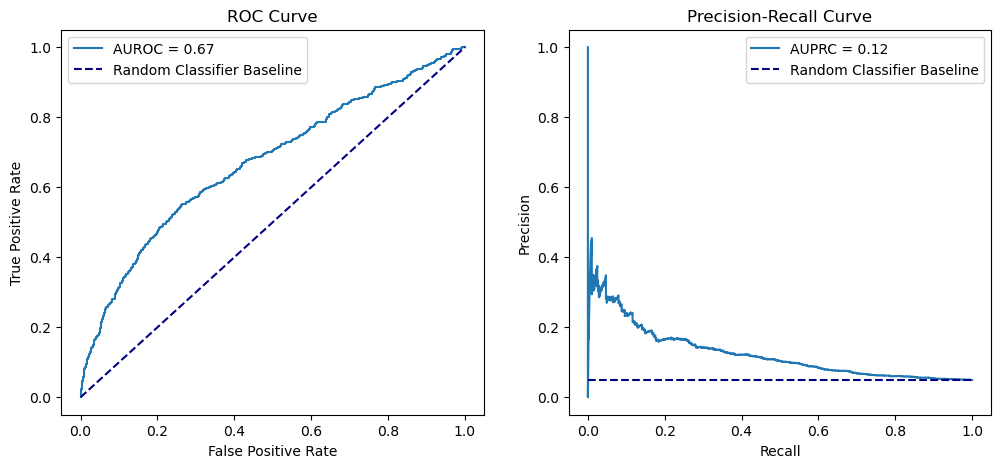

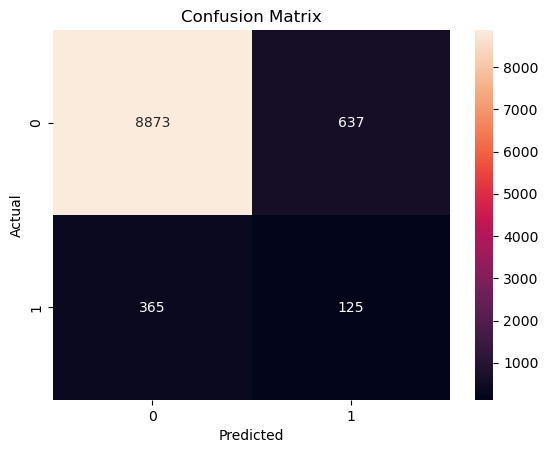

AUROC: 0.6713944505246894, AUPRC: 0.12472070912831136, Max F1 Score: 0.20111731843575417


In [29]:

import numpy as np
import pandas as pd
import shap
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, roc_curve, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr,spearmanr

# Function to load data
def load_data(expression_file):
    data = pd.read_csv(expression_file, sep="\t")
    tf_expression = data.iloc[:, :100].values  # Assuming TFs are the first 100 columns
    tg_expression = data.iloc[:, 100:].values  # Assuming TGs are the next 100 columns
    return tf_expression, tg_expression

# Function to train models and calculate SHAP values
def train_models_with_shap(tf_expression, tg_expression):
    models = []
    shap_values_list = []
    for i in range(tg_expression.shape[1]):
        model = RandomForestRegressor(n_estimators=100,max_features=None,random_state=6517)
        model.fit(tf_expression, tg_expression[:, i])

        # Calculate SHAP values
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(tf_expression)
        shap_values_list.append(shap_values)

        models.append(model)
    return models, shap_values_list

# Function to infer GRN with SHAP scores
def infer_grn_with_shap_scores(models, shap_values_list):
    scores = np.zeros((100, 100))  # Assuming 100 TFs and 100 TGs
    for i, shap_values in enumerate(shap_values_list):
        importance = np.abs(shap_values).mean(axis=0)
        scores[:, i] = importance
    return scores

# Weighted Correlation Pruning Function
def weighted_spearman_pruning(shap_scores, expression_data, weight_factor):
    weighted_scores = np.zeros_like(shap_scores)
    num_tfs = shap_scores.shape[0]
    num_tgs = shap_scores.shape[1]

    for tf in range(num_tfs):
        for tg in range(num_tgs):
            tg_index = num_tfs + tg  # Adjust index for TGs
            correlation, _ = spearmanr(expression_data[:, tf], expression_data[:, tg_index])
            weighted_scores[tf, tg] = shap_scores[tf, tg] * (1 + abs(correlation) * weight_factor)

    return weighted_scores

# Evaluation function
def evaluate_metrics(tf_expression, tg_expression, scores, ground_truth_file):
    ground_truth = pd.read_csv(ground_truth_file, header=None)
    y_true = np.zeros_like(scores, dtype=int)
    for _, (tf, tg) in ground_truth.iterrows():
        y_true[tf, tg-100] = 1

    scores_flat = scores.flatten()
    y_true_flat = y_true.flatten()

    auroc = roc_auc_score(y_true_flat, scores_flat)
    auprc = average_precision_score(y_true_flat, scores_flat)

    precision, recall, thresholds = precision_recall_curve(y_true_flat, scores_flat)
    f1_scores = [2 * p * r / (p + r) for p, r in zip(precision, recall) if p + r > 0]
    max_f1_index = np.argmax(f1_scores)
    max_f1 = f1_scores[max_f1_index]
    best_threshold = thresholds[max_f1_index]

    fpr, tpr, _ = roc_curve(y_true_flat, scores_flat)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f'AUROC = {auroc:.2f}')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Random Classifier Baseline')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label=f'AUPRC = {auprc:.2f}')
    no_skill = sum(y_true_flat) / len(y_true_flat)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', color='navy', label='Random Classifier Baseline')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

    predictions = (scores_flat > best_threshold).astype(int)
    cm = confusion_matrix(y_true_flat, predictions)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    return auroc, auprc, max_f1, best_threshold

# Load your data
expression_file = r'C:\Users\Neel Patel\Documents\Github Repositories\Machine-Learning-Biosciences-Final-Project\Project1\5_mr_50_cond\simulated_noNoise.txt'
ground_truth_file = r'C:\Users\Neel Patel\Documents\Github Repositories\Machine-Learning-Biosciences-Final-Project\Project1\5_mr_50_cond\bipartite_GRN.csv'

tf_expression, tg_expression = load_data(expression_file)

# Concatenate TF and TG expression data for correlation analysis
expression_data = np.concatenate([tf_expression, tg_expression], axis=1)

# Train models and calculate SHAP values
models, shap_values_list = train_models_with_shap(tf_expression, tg_expression)

# Get SHAP scores from the GRN models
shap_scores = infer_grn_with_shap_scores(models, shap_values_list)

# Apply weighted correlation pruning
pruned_scores = weighted_spearman_pruning(shap_scores, expression_data, weight_factor=0.5)

# Evaluate and display metrics for the pruned GRN
auroc, auprc, max_f1, _ = evaluate_metrics(tf_expression, tg_expression, pruned_scores, ground_truth_file)
print(f"AUROC: {auroc}, AUPRC: {auprc}, Max F1 Score: {max_f1}")




## Mutual information and SHAP scores combined by arthimetic average


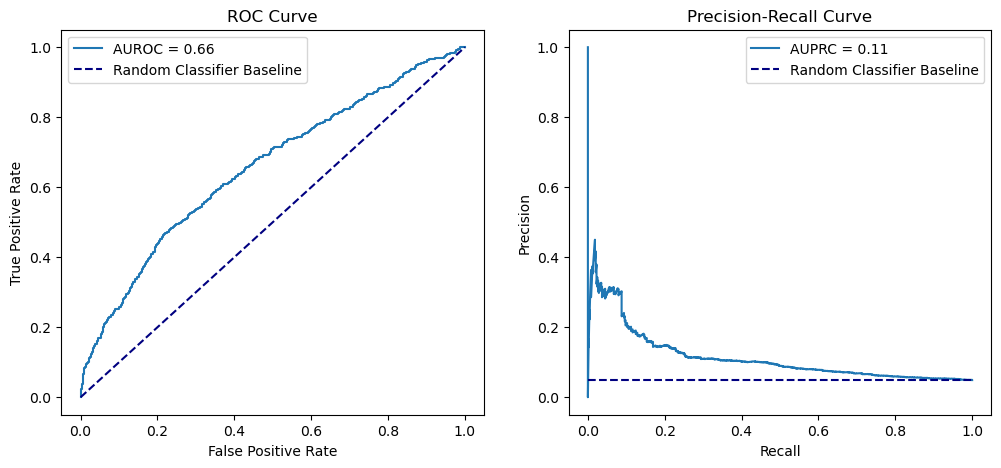

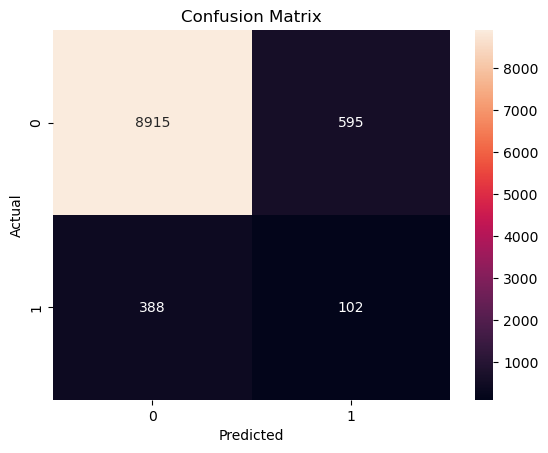

AUROC: 0.6558046310006652, AUPRC: 0.11382564733064707, Max F1 Score: 0.17340067340067342


In [30]:
import numpy as np
import pandas as pd
import shap
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, roc_curve, confusion_matrix, f1_score
from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt
import seaborn as sns

# Function to load data
def load_data(expression_file):
    data = pd.read_csv(expression_file, sep="\t")
    tf_expression = data.iloc[:, :100].values  # Assuming TFs are the first 100 columns
    tg_expression = data.iloc[:, 100:].values  # Assuming TGs are the next 100 columns
    return tf_expression, tg_expression

# Function to train models and calculate SHAP values
def train_models_with_shap(tf_expression, tg_expression):
    models = []
    shap_values_list = []
    for i in range(tg_expression.shape[1]):
        model = RandomForestRegressor(n_estimators=100,max_features=None,random_state=6517)
        model.fit(tf_expression, tg_expression[:, i])

        # Calculate SHAP values
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(tf_expression)
        shap_values_list.append(shap_values)

        models.append(model)
    return models, shap_values_list

# Function to infer GRN with SHAP scores
def infer_grn_with_shap_scores(models, shap_values_list):
    scores = np.zeros((100, 100))  # Assuming 100 TFs and 100 TGs
    for i, shap_values in enumerate(shap_values_list):
        importance = np.abs(shap_values).mean(axis=0)
        scores[:, i] = importance
    return scores

# Function to calculate mutual information
def calculate_mutual_information(tf_expression, tg_expression):
    mi_scores = np.zeros((tf_expression.shape[1], tg_expression.shape[1]))  # 100 TFs x 100 TGs
    for i in range(tg_expression.shape[1]):
        mi_scores[:, i] = mutual_info_regression(tf_expression, tg_expression[:, i])
    return mi_scores

# Function to integrate SHAP and MI scores
def integrate_shap_mi(shap_scores, mi_scores):
    normalized_shap = shap_scores / np.max(shap_scores)
    normalized_mi = mi_scores / np.max(mi_scores)
    combined_scores = (normalized_shap + normalized_mi) / 2
    return combined_scores

# Evaluation function
def evaluate_metrics(tf_expression, tg_expression, scores, ground_truth_file):
    ground_truth = pd.read_csv(ground_truth_file, header=None)
    y_true = np.zeros_like(scores, dtype=int)
    for _, (tf, tg) in ground_truth.iterrows():
        y_true[tf, tg-100] = 1

    scores_flat = scores.flatten()
    y_true_flat = y_true.flatten()

    auroc = roc_auc_score(y_true_flat, scores_flat)
    auprc = average_precision_score(y_true_flat, scores_flat)

    precision, recall, thresholds = precision_recall_curve(y_true_flat, scores_flat)
    f1_scores = [2 * p * r / (p + r) for p, r in zip(precision, recall) if p + r > 0]
    max_f1_index = np.argmax(f1_scores)
    max_f1 = f1_scores[max_f1_index]
    best_threshold = thresholds[max_f1_index]

    fpr, tpr, _ = roc_curve(y_true_flat, scores_flat)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f'AUROC = {auroc:.2f}')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Random Classifier Baseline')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label=f'AUPRC = {auprc:.2f}')
    no_skill = sum(y_true_flat) / len(y_true_flat)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', color='navy', label='Random Classifier Baseline')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

    predictions = (scores_flat > best_threshold).astype(int)
    cm = confusion_matrix(y_true_flat, predictions)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    return auroc, auprc, max_f1, best_threshold

# Load your data

expression_file = r'C:\Users\Neel Patel\Documents\Github Repositories\Machine-Learning-Biosciences-Final-Project\Project1\5_mr_50_cond\simulated_noNoise.txt'
ground_truth_file = r'C:\Users\Neel Patel\Documents\Github Repositories\Machine-Learning-Biosciences-Final-Project\Project1\5_mr_50_cond\bipartite_GRN.csv'

tf_expression, tg_expression = load_data(expression_file)

# Train models and calculate SHAP values
models, shap_values_list = train_models_with_shap(tf_expression, tg_expression)
shap_scores = infer_grn_with_shap_scores(models, shap_values_list)

# Calculate mutual information
mi_scores = calculate_mutual_information(tf_expression, tg_expression)

# Integrate SHAP and MI scores
combined_scores = integrate_shap_mi(shap_scores, mi_scores)

# Evaluate and display metrics for the combined score-based GRN
auroc, auprc, max_f1, _ = evaluate_metrics(tf_expression, tg_expression, combined_scores, ground_truth_file)
print(f"AUROC: {auroc}, AUPRC: {auprc}, Max F1 Score: {max_f1}")


## Harmonic Mean with shap and mutual information

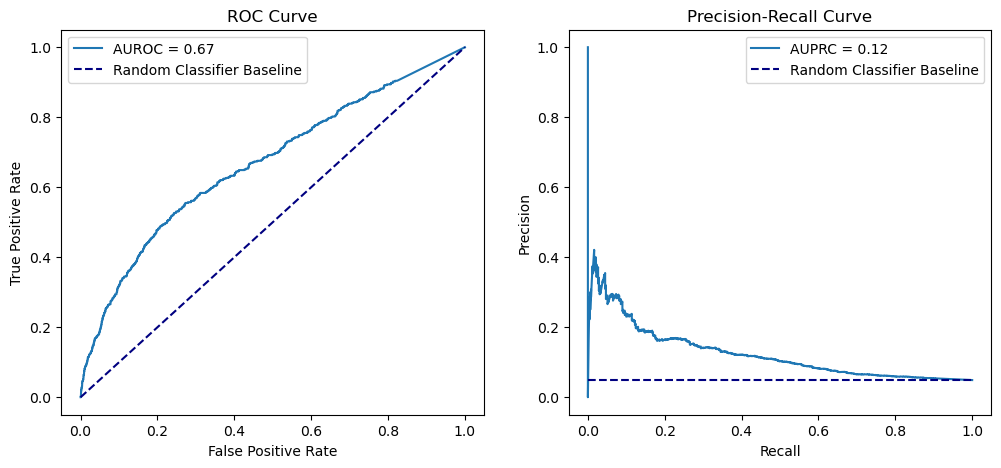

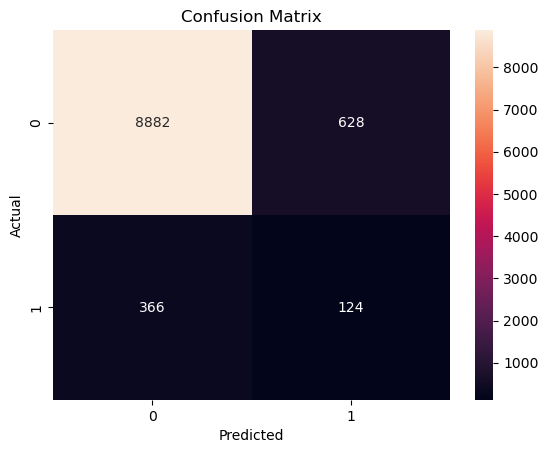

AUROC: 0.6679571450031117, AUPRC: 0.12424583102347281, Max F1 Score: 0.20112630732099757


In [31]:
import numpy as np
import pandas as pd
import shap
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, roc_curve, confusion_matrix, f1_score
from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt
import seaborn as sns

# Function to load data
def load_data(expression_file):
    data = pd.read_csv(expression_file, sep="\t")
    tf_expression = data.iloc[:, :100].values  # Assuming TFs are the first 100 columns
    tg_expression = data.iloc[:, 100:].values  # Assuming TGs are the next 100 columns
    return tf_expression, tg_expression

# Function to train models and calculate SHAP values
def train_models_with_shap(tf_expression, tg_expression):
    models = []
    shap_values_list = []
    for i in range(tg_expression.shape[1]):
        model = RandomForestRegressor(n_estimators=100,max_features=None,random_state=6517)
        model.fit(tf_expression, tg_expression[:, i])

        # Calculate SHAP values
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(tf_expression)
        shap_values_list.append(shap_values)

        models.append(model)
    return models, shap_values_list

# Function to infer GRN with SHAP scores
def infer_grn_with_shap_scores(models, shap_values_list):
    scores = np.zeros((100, 100))  # Assuming 100 TFs and 100 TGs
    for i, shap_values in enumerate(shap_values_list):
        importance = np.abs(shap_values).mean(axis=0)
        scores[:, i] = importance
    return scores

# Function to calculate mutual information
def calculate_mutual_information(tf_expression, tg_expression):
    mi_scores = np.zeros((tf_expression.shape[1], tg_expression.shape[1]))  # 100 TFs x 100 TGs
    for i in range(tg_expression.shape[1]):
        mi_scores[:, i] = mutual_info_regression(tf_expression, tg_expression[:, i])
    return mi_scores

# Function to integrate SHAP and MI scores using harmonic mean
def integrate_shap_mi_harmonic_mean(shap_scores, mi_scores):
    normalized_shap = shap_scores / np.max(shap_scores)
    normalized_mi = mi_scores / np.max(mi_scores)
    combined_scores = 2 * (normalized_shap * normalized_mi) / (normalized_shap + normalized_mi + 1e-8)  # Avoid division by zero
    return combined_scores

# Evaluation function
def evaluate_metrics(tf_expression, tg_expression, scores, ground_truth_file):
    ground_truth = pd.read_csv(ground_truth_file, header=None)
    y_true = np.zeros_like(scores, dtype=int)
    for _, (tf, tg) in ground_truth.iterrows():
        y_true[tf, tg-100] = 1

    scores_flat = scores.flatten()
    y_true_flat = y_true.flatten()

    auroc = roc_auc_score(y_true_flat, scores_flat)
    auprc = average_precision_score(y_true_flat, scores_flat)

    precision, recall, thresholds = precision_recall_curve(y_true_flat, scores_flat)
    f1_scores = [2 * p * r / (p + r) for p, r in zip(precision, recall) if p + r > 0]
    max_f1_index = np.argmax(f1_scores)
    max_f1 = f1_scores[max_f1_index]
    best_threshold = thresholds[max_f1_index]

    fpr, tpr, _ = roc_curve(y_true_flat, scores_flat)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f'AUROC = {auroc:.2f}')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Random Classifier Baseline')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label=f'AUPRC = {auprc:.2f}')
    no_skill = sum(y_true_flat) / len(y_true_flat)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', color='navy', label='Random Classifier Baseline')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

    predictions = (scores_flat > best_threshold).astype(int)
    cm = confusion_matrix(y_true_flat, predictions)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    return auroc, auprc, max_f1, best_threshold

# Load your data

expression_file = r'C:\Users\Neel Patel\Documents\Github Repositories\Machine-Learning-Biosciences-Final-Project\Project1\5_mr_50_cond\simulated_noNoise.txt'
ground_truth_file = r'C:\Users\Neel Patel\Documents\Github Repositories\Machine-Learning-Biosciences-Final-Project\Project1\5_mr_50_cond\bipartite_GRN.csv'

tf_expression, tg_expression = load_data(expression_file)

# Train models and calculate SHAP values
models, shap_values_list = train_models_with_shap(tf_expression, tg_expression)
shap_scores = infer_grn_with_shap_scores(models, shap_values_list)

# Calculate mutual information
mi_scores = calculate_mutual_information(tf_expression, tg_expression)

# Integrate SHAP and MI scores
combined_scores = integrate_shap_mi_harmonic_mean(shap_scores, mi_scores)

# Evaluate and display metrics for the combined score-based GRN
auroc, auprc, max_f1, _ = evaluate_metrics(tf_expression, tg_expression, combined_scores, ground_truth_file)
print(f"AUROC: {auroc}, AUPRC: {auprc}, Max F1 Score: {max_f1}")

# PCA and standardization (FAILED) MAYBE JUST STANDARDIZE DATA

HERE ARE TP,FP,FN
97 492 393
Precision: 0.16468590831918506, Recall: 0.19795918367346937


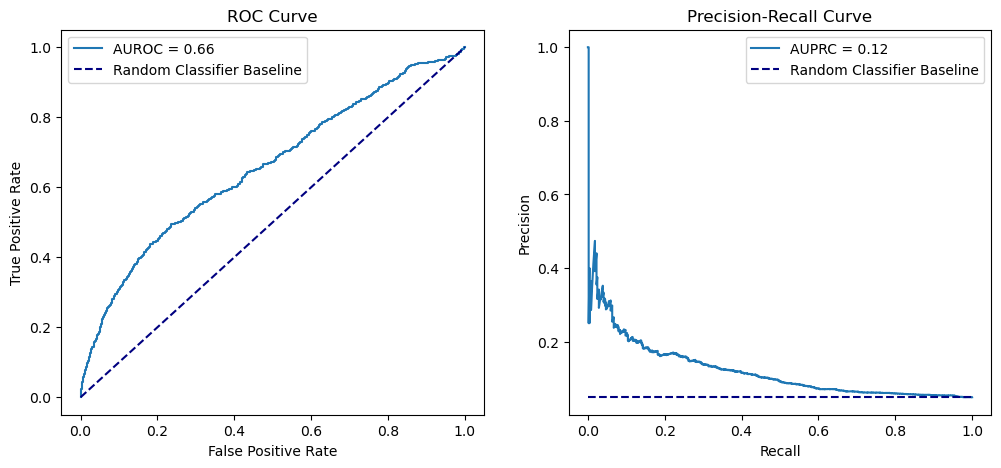

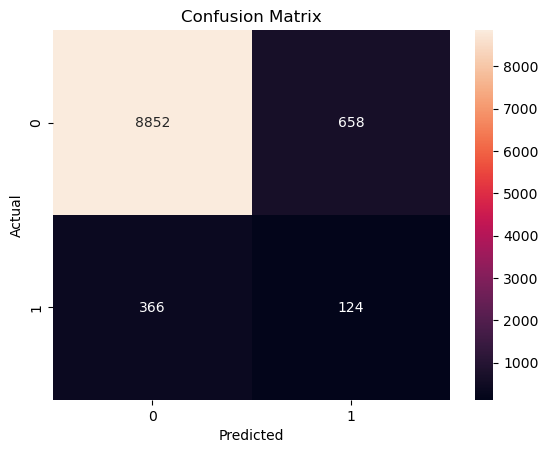

AUROC: 0.6563733127320329, AUPRC: 0.12162941712044993, Max F1 Score: 0.19638648860958366, Best Threshold: 0.022618131306600474


In [33]:
import numpy as np
import pandas as pd
import shap
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, roc_curve, confusion_matrix, f1_score
from sklearn.feature_selection import mutual_info_regression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Function to load and standardize data
def load_and_standardize_data(expression_file):
    data = pd.read_csv(expression_file, sep="\t")
    tf_expression = data.iloc[:, :100].values  # Assuming TFs are the first 100 columns
    tg_expression = data.iloc[:, 100:].values  # Assuming TGs are the next 100 columns
    
    # Standardize the data
    scaler = StandardScaler()
    tf_expression = scaler.fit_transform(tf_expression)
    tg_expression = scaler.transform(tg_expression)  # Use same scaler to ensure consistent scaling
    
    return tf_expression, tg_expression

def train_models(tf_expression, tg_expression):
    models = []
    for i in range(tg_expression.shape[1]):
        model = RandomForestRegressor(n_estimators=100,max_features=None,random_state=6517,criterion='friedman_mse')
        model.fit(tf_expression, tg_expression[:, i])
        models.append(model)
    return models

def infer_grn(models, threshold=0.03199140873560253):
    grn_edges = []
    for i, model in enumerate(models):
        importance = model.feature_importances_
        regulators = np.where(importance > threshold)[0]
        for reg in regulators:
            grn_edges.append((reg, i+100))  # TF ids are 0-99, TG ids are 100-199
      
    return grn_edges

def evaluate_grn(predicted_edges, ground_truth_file):
    ground_truth = pd.read_csv(ground_truth_file, header=None)
    ground_truth.head()
    ground_truth_set = set(tuple(x) for x in ground_truth.values)
    predicted_set = set(predicted_edges) #convert into a set to get the unique ordered pairs (also can't edit the sets themselves)
    
    tp = len(predicted_set & ground_truth_set)
    fp = len(predicted_set - ground_truth_set)
    fn = len(ground_truth_set - predicted_set)
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    print("HERE ARE TP,FP,FN")  
    print(tp,fp,fn)
    return precision, recall

def infer_grn_scores(models):
    scores = []
    for model in models:
        # Using feature importances as the score
        scores.append(model.feature_importances_)
    return np.array(scores).T  # Transpose to align with the shape of tf_expression

def evaluate_metrics(tf_expression, tg_expression, scores, ground_truth_file):
    # Prepare ground truth labels
    ground_truth = pd.read_csv(ground_truth_file, header=None)
    y_true = np.zeros_like(scores, dtype=int)
    for _, (tf, tg) in ground_truth.iterrows():
        y_true[tf, tg-100] = 1  # Adjust index for TGs

    # Flatten arrays for evaluations
    scores_flat = scores.flatten()
    y_true_flat = y_true.flatten()

    # Compute AUROC and AUPRC
    auroc = roc_auc_score(y_true_flat, scores_flat)
    auprc = average_precision_score(y_true_flat, scores_flat)

    # Compute precision-recall curve and F1 score
    precision, recall, thresholds = precision_recall_curve(y_true_flat, scores_flat)
    f1_scores = [2 * p * r / (p + r) for p, r in zip(precision, recall) if p + r > 0]
    max_f1_index = np.argmax(f1_scores)
    max_f1 = f1_scores[max_f1_index]
    best_threshold = thresholds[max_f1_index]

    # Plotting ROC Curve
    fpr, tpr, _ = roc_curve(y_true_flat, scores_flat)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f'AUROC = {auroc:.2f}')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Random Classifier Baseline')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()

    # Plotting Precision-Recall Curve
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label=f'AUPRC = {auprc:.2f}')
    no_skill = sum(y_true_flat) / len(y_true_flat)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', color='navy', label='Random Classifier Baseline')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

    # Displaying the confusion matrix for the best F1 score
    predictions = (scores_flat > best_threshold).astype(int)
    cm = confusion_matrix(y_true_flat, predictions)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    return auroc, auprc, max_f1, best_threshold
# Load your data

expression_file = r'C:\Users\Neel Patel\Documents\Github Repositories\Machine-Learning-Biosciences-Final-Project\Project1\5_mr_50_cond\simulated_noNoise.txt'
ground_truth_file = r'C:\Users\Neel Patel\Documents\Github Repositories\Machine-Learning-Biosciences-Final-Project\Project1\5_mr_50_cond\bipartite_GRN.csv'

# Load your data and adjust file path as necessary!
tf_expression, tg_expression = load_and_standardize_data(expression_file)

# Train a model for each target gene
models = train_models(tf_expression, tg_expression)

# Infer the gene regulatory network
predicted_grn_edges = infer_grn(models)

# Evaluate the GRN
precision, recall= evaluate_grn(predicted_grn_edges, ground_truth_file)

print(f"Precision: {precision}, Recall: {recall}")

# Get scores from the GRN models
scores = infer_grn_scores(models)

# Evaluate and display metrics
auroc, auprc, max_f1, best_threshold = evaluate_metrics(tf_expression, tg_expression, scores, ground_truth_file)
print(f"AUROC: {auroc}, AUPRC: {auprc}, Max F1 Score: {max_f1}, Best Threshold: {best_threshold}")
